# New York Yellow Taxi Cabs Demand Prediction

Objective: Predict the approximate number of pickups the cab drivers can get for a particular region in 10 minute time intervals.

Constraints:
- Clusters - Cluster the city into regions by ride demand. Clusters should be between 0.5 miles to 2 miles from the center.
- Time - The time interval for demand should be 10 minutes.
- Latency - It should take a few seconds to fetch the data.
- Interpretability - Interpretability is not a concern.

### About the daataset:

We have collected all yellow taxi trip data of jan-2015 and jan-2016. From - https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

The datasets were collected and provided to the NYC Taxi and Limousine Commission (TLC).

#### Features in the datasets

- VendorID - A code indicating the TPEP provider that provided the record.<br>
1 = Creative Mobile Technologies, LLC <br>
2 = VeriFone Inc.

- tpep_pickup_datetime - The date and time when the meter was engaged.

- tpep_dropoff_datetime - The date and time when the meter was disengaged.

- passenger_count - The number of passengers in the vehicle. This is a driver-entered value.

- trip_distance - The elapsed trip distance in miles reported by the taximeter.

- pickup_longitude - Longitude of the pickup location.

- pickup_latitude - Latitude of the pickup location.

- RateCodeID - The final rate code in effect at the end of the trip. <br>
1 = Standard rate<br>
2 = JFK<br>
3 = Newark<br>
4 = Nassau or Westchester<br>
5 = Negotiated fare<br>
6 = Group ride

- store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server.<br>
Y = store and forward trip<br>
N = not a store and forward trip

- dropoff_longitude - Longitude of the dropoff location.

- dropoff_latitude - Latitude of the dropoff location.

- payment_type - A numeric code signifying how the passenger paid for the trip. <br>
1 = Credit card<br>
2 = Cash<br>
3 = No charge<br>
4 = Dispute<br>
5 = Unknown<br>
6 = Voided trip

- fare_amount - The time-and-distance fare calculated by the meter.

- extra - Miscellaneous extras and surcharges. Currently, this only includes the $0.50 and 1 dollar rush hour and overnight charges.

- mta_tax - $0.50 MTA tax that is automatically triggered based on the metered rate in use.

- tip_amount - Tip amount. This field is automatically populated for credit card tips. Cash tips are not included.

- tolls_amount - Total amount of all tolls paid in the trip. 

- improvement_surcharge - $0.30 improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015.

- total_amount - The total amount charged to passengers. Does not include cash tips.



### Performance Metric
The performance metric that we will use will be MAPE (Mean Absolute Percentage Error). This will allow the drivers to know by how much percentage the predicted pickups can be off.



In [1]:
# Importing necessary libraries
import os
import time
import datetime
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import folium
import gpxpy.geo # Get the haversine distance
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

matplotlib.use('nbagg') # matplotlib uses this protocol which makes plots more user interactive.
plt.style.use('classic')
%matplotlib inline




In [2]:
df = pd.read_csv('yellow_tripdata_2015-01.csv')
df_test = pd.read_csv('yellow_tripdata_2016-01.csv')


In [3]:
df.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2015-01-15 19:05:39   2015-01-15 19:23:42                1   
1         1  2015-01-10 20:33:38   2015-01-10 20:53:28                1   
2         1  2015-01-10 20:33:38   2015-01-10 20:43:41                1   
3         1  2015-01-10 20:33:39   2015-01-10 20:35:31                1   
4         1  2015-01-10 20:33:39   2015-01-10 20:52:58                1   

   trip_distance  pickup_longitude  pickup_latitude  RateCodeID  \
0           1.59        -73.993896        40.750111           1   
1           3.30        -74.001648        40.724243           1   
2           1.80        -73.963341        40.802788           1   
3           0.50        -74.009087        40.713818           1   
4           3.00        -73.971176        40.762428           1   

  store_and_fwd_flag  dropoff_longitude  dropoff_latitude  payment_type  \
0                  N         -73.974785         40.750618             1   
1                  N         -73.994415         40.759109             1   
2                  N         -73.951820         40.824413             2   
3                  N         -74.004326         40.719986             2   
4                  N         -74.004181         40.742653             2   

   fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0         12.0    1.0      0.5        3.25           0.0   
1         14.5    0.5      0.5        2.00           0.0   
2          9.5    0.5      0.5        0.00           0.0   
3          3.5    0.5      0.5        0.00           0.0   
4         15.0    0.5      0.5        0.00           0.0   

   improvement_surcharge  total_amount  
0                    0.3         17.05  
1                    0.3         17.80  
2                    0.3         10.80  
3                    0.3          4.80  
4                    0.3         16.30

In [4]:
# Checking the shape of the dataframe
df.shape


(12748986, 19)

In [5]:
# Checking the columns in the train dataset
df.columns


Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')

In [6]:
# Checking the columns in the test dataset
df_test.columns


Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RatecodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')

In [7]:
# Checking the non-null count and datatype of the dataframe
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12748986 entries, 0 to 12748985
Data columns (total 19 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   VendorID               int64  
 1   tpep_pickup_datetime   object 
 2   tpep_dropoff_datetime  object 
 3   passenger_count        int64  
 4   trip_distance          float64
 5   pickup_longitude       float64
 6   pickup_latitude        float64
 7   RateCodeID             int64  
 8   store_and_fwd_flag     object 
 9   dropoff_longitude      float64
 10  dropoff_latitude       float64
 11  payment_type           int64  
 12  fare_amount            float64
 13  extra                  float64
 14  mta_tax                float64
 15  tip_amount             float64
 16  tolls_amount           float64
 17  improvement_surcharge  float64
 18  total_amount           float64
dtypes: float64(12), int64(4), object(3)
memory usage: 1.8+ GB


In [8]:
# Checking for null values
df.isnull().sum()


VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
pickup_longitude         0
pickup_latitude          0
RateCodeID               0
store_and_fwd_flag       0
dropoff_longitude        0
dropoff_latitude         0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    3
total_amount             0
dtype: int64

In [9]:
# Dropping the null values
df.dropna(inplace=True)


# EDA and Data Cleaning

## 1. Pickup Latitude and Pickup Longitude

New York is bounded by location coordinates (lat,long) - (40.5774, -74.15) & (40.9176, -73.7004) so hence any coordinates not within these corrdinates are not considered by us as we are only concerned with pickups which originate within New York.

We will spot first 10000 outliers on the map, plotting all the outliers will take more time.

In [10]:
# Plotting pick up coordinates which are outside the bounding box of New York
# We will collect all the points outside the bounding box of New York City to outlier_locations
outlier_locations = df[((df['pickup_longitude'] <= -74.15) | (df['pickup_latitude'] <= 40.5774) | 
                           (df['pickup_longitude'] >= -73.7004) | (df['pickup_latitude'] >= 40.9176))]

map_osm = folium.Map(location=[40.774695, -73.990372])

sample_locations = outlier_locations.head(10000)
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['pickup_latitude'],j['pickup_longitude']))).add_to(map_osm)

map_osm



Observation:- As you can see above that there are some points just outside the boundary but there are a few that are in either South America or Mexico.

## 2. Dropoff Latitude and Dropoff Longitude

In [11]:
outlier_locations = df[((df['dropoff_longitude'] <= -74.15) | (df['dropoff_latitude'] <= 40.5774) | 
                           (df['dropoff_longitude'] >= -73.7004) | (df['dropoff_latitude'] >= 40.9176))]

map_osm = folium.Map(location=[40.774695, -73.990372])

sample_locations = outlier_locations.head(10000)
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['dropoff_latitude'],j['dropoff_longitude']))).add_to(map_osm)

map_osm



## 3. Trip Duration

According to NYC taxi and limousine commission regulations the maximum allowed trip duration in a 24 hour interval is 12 hours.

The timestamps are converted to unix so as to get duration (trip-time) & speed. Also, pick up times in unix are used while binning.

In [12]:
def convert_to_unix(s):
    '''Returns the IST unix time for a given datetime '''
    
    return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())

def return_with_trip_times(df):
    '''Returns the given dataframe with three new columns trip_time, pickup_time, and speed.'''
    
    duration = df[['tpep_pickup_datetime', 'tpep_dropoff_datetime']]
    
    # pickups and dropoffs to unix time
    duration_pickup = [convert_to_unix(x) for x in duration['tpep_pickup_datetime'].values]
    duration_drop = [convert_to_unix(x) for x in duration['tpep_dropoff_datetime'].values]
    
    # calculate duration of trips
    durations = (np.array(duration_drop) - np.array(duration_pickup))/60 

    # append durations to trips and speed in miles/hour to a new dataframe
    new_df = df[['passenger_count', 'trip_distance', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'total_amount']]
    
    new_df['trip_time'] = durations
    new_df['pickup_time'] = duration_pickup
    new_df['speed'] = 60*(new_df['trip_distance']/new_df['trip_time'])

    return new_df

df_with_duration = return_with_trip_times(df)



In [13]:
df_with_duration.head()

passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
0                1           1.59        -73.993896        40.750111   
1                1           3.30        -74.001648        40.724243   
2                1           1.80        -73.963341        40.802788   
3                1           0.50        -74.009087        40.713818   
4                1           3.00        -73.971176        40.762428   

   dropoff_longitude  dropoff_latitude  total_amount  trip_time   pickup_time  \
0         -73.974785         40.750618         17.05  18.050000  1.421329e+09   
1         -73.994415         40.759109         17.80  19.833333  1.420902e+09   
2         -73.951820         40.824413         10.80  10.050000  1.420902e+09   
3         -74.004326         40.719986          4.80   1.866667  1.420902e+09   
4         -74.004181         40.742653         16.30  19.316667  1.420902e+09   

       speed  
0   5.285319  
1   9.983193  
2  10.746269  
3  16.071429  
4   9.318378

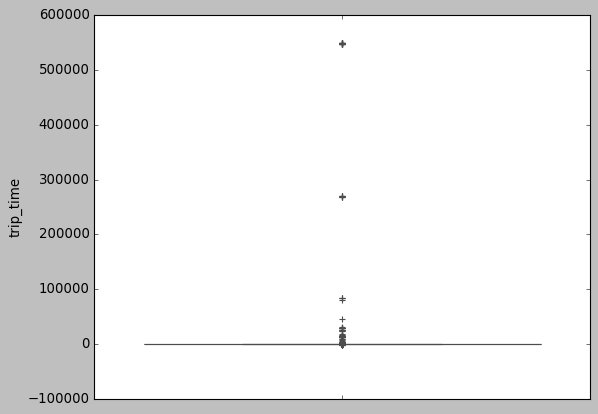

In [14]:
# the skewed boxplot shows us the presence of outliers
sns.boxplot(df_with_duration, y='trip_time')
plt.show()



In [15]:
# Calculating 0-100th percentile to find a correct percentile value for removal of Outliers
for i in np.linspace(0,1,11):
    print(f"{round(i*100)} percentile value is {df_with_duration['trip_time'].quantile(i)}")



0 percentile value is -1211.0166666666667
10 percentile value is 3.8333333333333335
20 percentile value is 5.383333333333334
30 percentile value is 6.816666666666666
40 percentile value is 8.3
50 percentile value is 9.95
60 percentile value is 11.866666666666667
70 percentile value is 14.283333333333333
80 percentile value is 17.633333333333333
90 percentile value is 23.45
100 percentile value is 548555.6333333333


In [16]:
# Looking further from the 90th percentile
for i in np.linspace(0.9,1,11):
    print(f"{round(i*100)} percentile value is {df_with_duration['trip_time'].quantile(i)}")



90 percentile value is 23.45
91 percentile value is 24.35
92 percentile value is 25.383333333333333
93 percentile value is 26.55
94 percentile value is 27.933333333333334
95 percentile value is 29.583333333333332
96 percentile value is 31.683333333333334
97 percentile value is 34.46666666666667
98 percentile value is 38.71666666666667
99 percentile value is 46.75
100 percentile value is 548555.6333333333


In [17]:
# Removing data based on our analysis and TLC regulations
df_with_duration = df_with_duration[(df_with_duration.trip_time>0) & (df_with_duration.trip_time<720)]


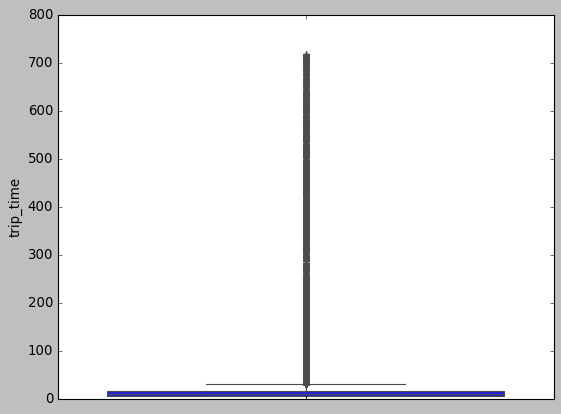

In [18]:
# boxplot after removal of outliers
sns.boxplot(df_with_duration, y='trip_time')
plt.show()



## 4. Speed

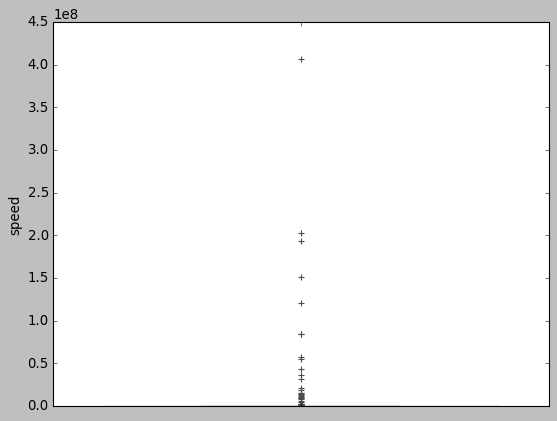

In [19]:
# Look for any outliers in the data after trip duration outliers removed
# Box plot for speed with outliers
sns.boxplot(df_with_duration, y='speed')
plt.show()



In [20]:
# Calculating 90-100th percentile to find a correct percentile value for removal of Outliers
for i in np.linspace(0.9,1,11):
    print(f"{round(i*100)} percentile value is {df_with_duration['speed'].quantile(i)}")



90 percentile value is 20.23374490740376
91 percentile value is 20.97087378640777
92 percentile value is 21.81818181818182
93 percentile value is 22.790152403282534
94 percentile value is 23.927492447129907
95 percentile value is 25.277208180421077
96 percentile value is 26.922888616891065
97 percentile value is 28.99192245557351
98 percentile value is 31.811487481590575
99 percentile value is 36.12429080515243
100 percentile value is 406256374.28571427


In [21]:
# Looking further from the 99th percentile
for i in np.linspace(0.99,1,11):
    print(f"{round(i*100,1)} percentile value is {df_with_duration['speed'].quantile(i)}")



99.0 percentile value is 36.12429080515243
99.1 percentile value is 36.71641791044775
99.2 percentile value is 37.37060525111119
99.3 percentile value is 38.093723607043
99.4 percentile value is 38.90801000903179
99.5 percentile value is 39.84
99.6 percentile value is 40.95531152224658
99.7 percentile value is 42.352941176470594
99.8 percentile value is 44.4
99.9 percentile value is 49.44450617725624
100.0 percentile value is 406256374.28571427


In [22]:
# Removing further outliers based on the 99.9th percentile values
df_with_duration = df_with_duration[(df_with_duration.speed>0) & (df_with_duration.speed<45.31)]



In [23]:
# Average speed of cabs in New York in miles/hour
sum(df_with_duration.speed)/len(df_with_duration.speed)



12.458637835593864

The average speed in New York is 12.45 mph, so a cab driver can travel 2 miles per 10 minutes on average.



## 5. Trip Distance

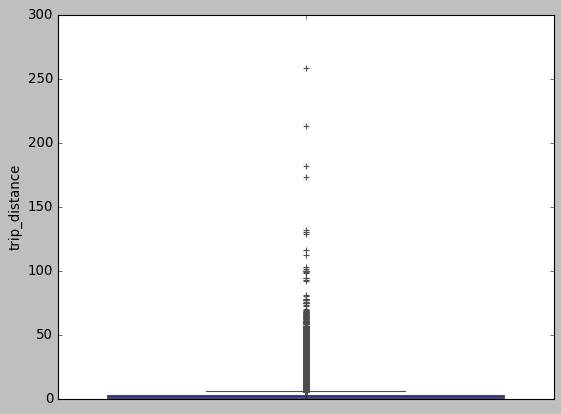

In [24]:
# Up till now we have removed the outliers based on trip duration and cab speeds
# Let's try if there are any outlets in trip distance
# boxplot showing outliers in trip distance values
sns.boxplot(df_with_duration, y='trip_distance')
plt.show()




In [25]:
# Calculating 0-100th percentile to find a correct percentile value for removal of Outliers
for i in np.linspace(0,1,11):
    print(f"{round(i*100)} percentile value is {df_with_duration['trip_distance'].quantile(i)}")



0 percentile value is 0.01
10 percentile value is 0.66
20 percentile value is 0.9
30 percentile value is 1.1
40 percentile value is 1.39
50 percentile value is 1.69
60 percentile value is 2.07
70 percentile value is 2.6
80 percentile value is 3.6
90 percentile value is 5.96
100 percentile value is 258.9


In [26]:
# Looking further from the 90th percentile
for i in np.linspace(0.9,1,11):
    print(f"{round(i*100)} percentile value is {df_with_duration['trip_distance'].quantile(i)}")



90 percentile value is 5.96
91 percentile value is 6.45
92 percentile value is 7.07
93 percentile value is 7.84
94 percentile value is 8.72
95 percentile value is 9.6
96 percentile value is 10.6
97 percentile value is 12.1
98 percentile value is 16.03
99 percentile value is 18.17
100 percentile value is 258.9


In [27]:
# Looking further from the 99th percentile
for i in np.linspace(0.99,1,11):
    print(f"{round(i*100, 1)} percentile value is {df_with_duration['trip_distance'].quantile(i)}")



99.0 percentile value is 18.17
99.1 percentile value is 18.36
99.2 percentile value is 18.6
99.3 percentile value is 18.83
99.4 percentile value is 19.13
99.5 percentile value is 19.5
99.6 percentile value is 19.96
99.7 percentile value is 20.5
99.8 percentile value is 21.22
99.9 percentile value is 22.57
100.0 percentile value is 258.9


In [28]:
# Removing further outliers based on the 99.9th percentile values
df_with_duration = df_with_duration[(df_with_duration.trip_distance>0) & (df_with_duration.trip_distance<23)]



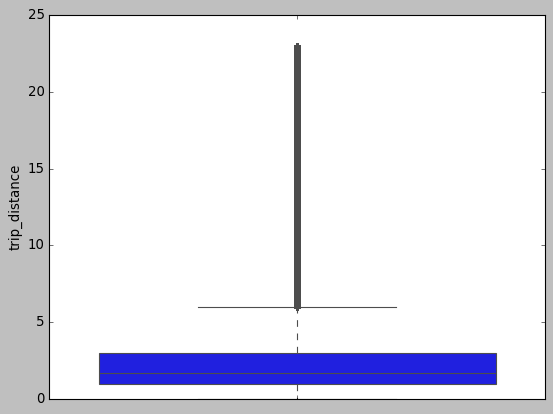

In [29]:
# boxplot after removal of outliers
sns.boxplot(df_with_duration, y='trip_distance')
plt.show()



## 6. Total Fare

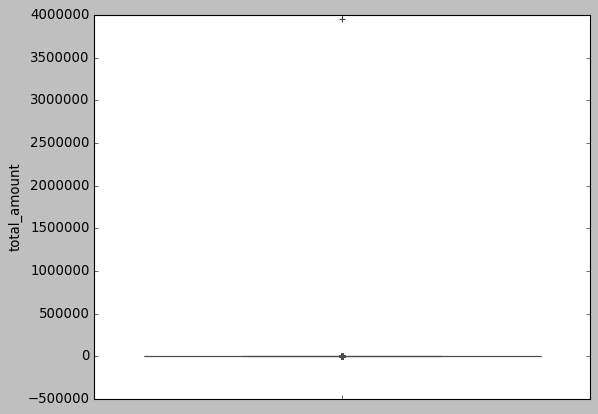

In [30]:
# Up till now we have removed outliers based on trip durations, cab speeds and trip distances
# Let's try if there are any outliers in total_amount
# boxplot showing outliers in total_amount
sns.boxplot(df_with_duration, y='total_amount')
plt.show()



In [31]:
# Calculating 0-100th percentile to find a correct percentile value for removal of Outliers
for i in np.linspace(0,1,11):
    print(f"{round(i*100)} percentile value is {df_with_duration['total_amount'].quantile(i)}")



0 percentile value is -242.55
10 percentile value is 6.35
20 percentile value is 7.8
30 percentile value is 8.8
40 percentile value is 9.8
50 percentile value is 11.16
60 percentile value is 12.8
70 percentile value is 14.8
80 percentile value is 18.3
90 percentile value is 25.8
100 percentile value is 3950611.6


In [32]:
# Looking further from the 90th percentile
for i in np.linspace(0.9,1,11):
    print(f"{round(i*100)} percentile value is {df_with_duration['total_amount'].quantile(i)}")



90 percentile value is 25.8
91 percentile value is 27.3
92 percentile value is 29.12
93 percentile value is 31.55
94 percentile value is 34.63
95 percentile value is 38.15
96 percentile value is 42.13
97 percentile value is 47.56
98 percentile value is 57.76
99 percentile value is 65.93
100 percentile value is 3950611.6


In [33]:
# Looking further from the 99th percentile
for i in np.linspace(0.99,1,11):
    print(f"{round(i*100, 1)} percentile value is {df_with_duration['total_amount'].quantile(i)}")



99.0 percentile value is 65.93
99.1 percentile value is 67.8
99.2 percentile value is 69.06
99.3 percentile value is 69.6
99.4 percentile value is 69.73
99.5 percentile value is 69.73
99.6 percentile value is 69.76
99.7 percentile value is 72.46
99.8 percentile value is 75.3
99.9 percentile value is 87.0
100.0 percentile value is 3950611.6


Observation - As even the 99.9th percentile value doesn't look like an outlier, as there is not much difference between the 99.8th percentile and 99.9th percentile we move on to do graphical analysis

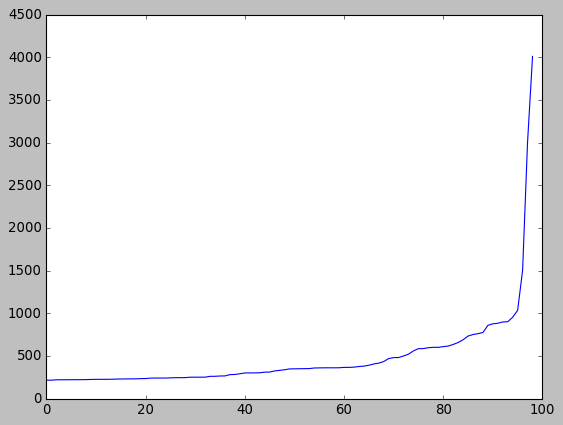

In [34]:
# Below plot shows us the sorted fare values to find a sharp increase to remove those values as outliers
# Plot the 100 highest fair amounts excluding the last value in sorted data
plt.plot(df_with_duration['total_amount'].sort_values()[-100:-1].values)
plt.show()



A very sharp increase in total amount can be seen. 

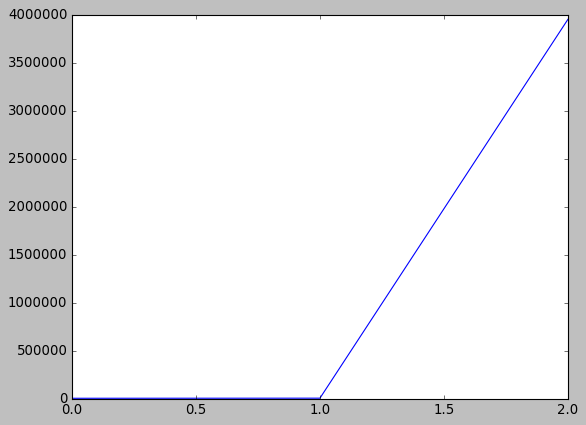

In [35]:
# Plotting last three total fare valuse and we can observe there is sharp increase in the values
plt.plot(df_with_duration['total_amount'].sort_values()[-3:].values)
plt.show()



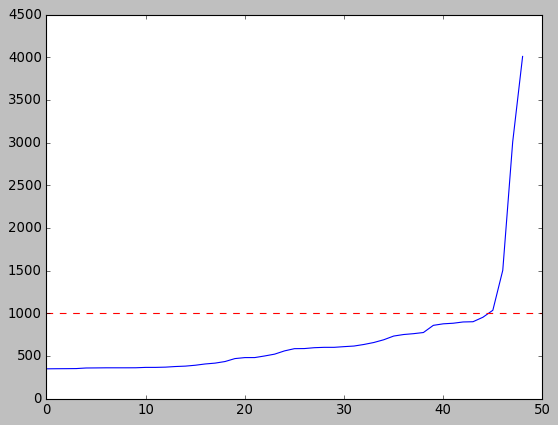

In [36]:
# Plot the 50 highest fair amounts excluding the last value in sorted data
plt.plot(df_with_duration['total_amount'].sort_values()[-50:-1].values)
plt.axhline(1000, c='r', ls='--')
plt.show()



In [37]:
# Removing all outliers based on our analysis
df_with_duration = df_with_duration[(df_with_duration.total_amount>0) & (df_with_duration.total_amount<1000)]



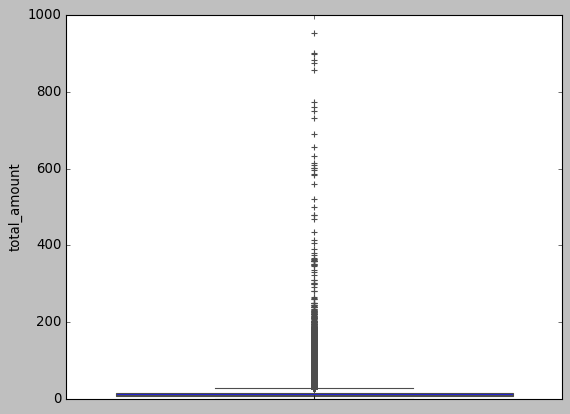

In [38]:
# boxplot after removal of outliers
sns.boxplot(df_with_duration, y='total_amount')
plt.show()



## 7. Pickup and Dropoff Latitudes and Longitudes

In [39]:
df_with_duration = df_with_duration[(df_with_duration.pickup_longitude >= -74.15) & (df_with_duration.pickup_longitude <= -73.7004) & 
                                    (df_with_duration.pickup_latitude >= 40.5774) & (df_with_duration.pickup_latitude <= 40.9176) & 
                                    (df_with_duration.dropoff_longitude >= -74.15) & (df_with_duration.dropoff_longitude <= -73.7004) & 
                                    (df_with_duration.dropoff_latitude >= 40.5774) & (df_with_duration.dropoff_latitude <= 40.9176)]

In [40]:
print("Total Outliers Removed:", df.shape[0] - df_with_duration.shape[0])
print("Fraction of Data Remaining: ", round(df_with_duration.shape[0]*100/df.shape[0], 2), '%', sep='')



Total Outliers Removed: 377907
Fraction of Data Remaining: 97.04%


# Data Preparation 

## Clustering/Segmentation

- We will cluster the regions based on the pickup density.
- The time interval is of 10 minutes.
- A cab travels 2 miles in 10 minutes on average.
- The distance between the centroids of two adjacent clusters should be around 2 miles but not less than 0.5 miles.

In [41]:
# Trying different cluster sizes to choose the right K in K-means
coords = df_with_duration[['pickup_latitude', 'pickup_longitude']].values
neighbors = []

def find_min_distance(cluster_centers, cluster_len):
    nice_points = 0
    wrong_points = 0
    less = []
    more = []
    min_dist = 1000
    for i in range(0, cluster_len):
        nice_points = 0
        wrong_points = 0
        for j in range(0, cluster_len):
            if j != i:
                distance = gpxpy.geo.haversine_distance(cluster_centers[i][0], cluster_centers[i][1], cluster_centers[j][0], cluster_centers[j][1])
                min_dist = min(min_dist, distance/(1.60934*1000))
                if (distance/(1.60934*1000)) <= 2:
                    nice_points += 1
                else:
                    wrong_points += 1
        less.append(nice_points)
        more.append(wrong_points)
    neighbors.append(less)
    avg_less = np.ceil(np.mean(less))
    avg_more = np.ceil(np.mean(more))
    print(f"For {cluster_len} clusters", "\nAverage number of Clusters within the vicinity (i.e. intercluster-distance < 2):", avg_less, 
          "\nAverage number of Clusters outside the vicinity (i.e. intercluster-distance > 2):", avg_more, 
          "\nMin inter-cluster distance =", min_dist, "\n---")

def find_clusters(increment):
    kmeans = MiniBatchKMeans(n_clusters=increment, batch_size=10000, random_state=42).fit(coords)
    df_with_duration['pickup_cluster'] = kmeans.predict(df_with_duration[['pickup_latitude', 'pickup_longitude']])
    cluster_centers = kmeans.cluster_centers_
    cluster_len = len(cluster_centers)
    return cluster_centers, cluster_len



In [42]:
# We need to choose the number of clusters so that, more cluster regions are close to any cluster center
# And make sure that the minimum inter-cluster distance should not be much less
for increment in range(10,100,10):
    cluster_centers, cluster_len = find_clusters(increment)
    find_min_distance(cluster_centers, cluster_len)

For 10 clusters 
Average number of Clusters within the vicinity (i.e. intercluster-distance < 2): 2.0 
Average number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 8.0 
Min inter-cluster distance = 0.9403042157013325 
---
For 20 clusters 
Average number of Clusters within the vicinity (i.e. intercluster-distance < 2): 4.0 
Average number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 15.0 
Min inter-cluster distance = 0.6591575997035559 
---
For 30 clusters 
Average number of Clusters within the vicinity (i.e. intercluster-distance < 2): 8.0 
Average number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 22.0 
Min inter-cluster distance = 0.4816324407604508 
---
For 40 clusters 
Average number of Clusters within the vicinity (i.e. intercluster-distance < 2): 11.0 
Average number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 29.0 
Min inter-cluster distance = 0.45331676035418483 
---
For 50 clusters 
Averag

In [43]:
# We need to choose the number of clusters so that, more cluster regions are close to any cluster center
# And make sure that the minimum inter-cluster distance should not be much less
# for increment in range(20,50):
#     cluster_centers, cluster_len = find_clusters(increment)
#     find_min_distance(cluster_centers, cluster_len)

<b>After analyzing the above output.</b>
- For 20 clusters or less the minimum inter-cluster distance is more than 0.65 miles.
- For 50 clusters or more the minimum inter-cluster distance is less than 0.35 miles.
- Minimum inter-cluster distance is desirable (around 0.5 miles) for cluster sizes of 30 and 40.
- For 30 clusters, the fraction of desirable clusters is 26.67%
- For 40 clusters, the fraction of desirable clusters is 27.5%

The main objective was to find an optimal minimum distance (which roughly estimates the radius of a cluster) between the clusters which we got 0.45 miles with 40 clusters.

In [44]:
# Let's choose 40 clusters to solve the problem further
# Getting 40 clusters using KMeans
kmeans = MiniBatchKMeans(n_clusters=40, batch_size=10000, random_state=0).fit(coords)
df_with_duration['pickup_cluster'] = kmeans.predict(df_with_duration[['pickup_latitude', 'pickup_longitude']])


### Plotting the clusters:

In [45]:
# Plotting the cluster centers on OSM
cluster_centers = kmeans.cluster_centers_
cluster_len = len(cluster_centers)
map_osm = folium.Map(location=[40.734695, -73.990372])
for i in range(cluster_len):
    folium.Marker(list((cluster_centers[i][0], cluster_centers[i][1])), popup=(str(cluster_centers[i][0])+', '+str(cluster_centers[i][1]))).add_to(map_osm)

map_osm



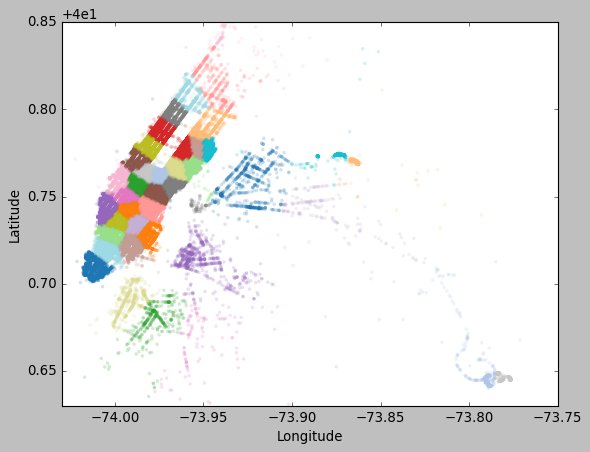

In [46]:
# Visualizing the clusters on a map
def plot_clusters(df):
    city_long_border = (-74.03, -73.75)
    city_lat_border = (40.63, 40.85)
    fig, ax = plt.subplots(1,1)
    ax.scatter(df['pickup_longitude'].values[:100000], df['pickup_latitude'].values[:100000], s=10, lw=0, 
               c=df['pickup_cluster'].values[:100000], cmap='tab20', alpha=0.2)
    ax.set_xlim(city_long_border)
    ax.set_ylim(city_lat_border)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.show()

plot_clusters(df_with_duration)



## Time Binning

Now we will bin the data in 10-minute time bins.

Total number of time bins = 31 days x 24 hours x 6 bins in an hour = 4464 bins

Refer: https://www.unixtimestamp.com/
- 1420070400 : 2015-01-01 00:00:00
- 1422748800 : 2015-02-01 00:00:00
- 1425168000 : 2015-03-01 00:00:00
- 1427846400 : 2015-04-01 00:00:00
- 1430438400 : 2015-05-01 00:00:00
- 1433116800 : 2015-06-01 00:00:00

- 1451606400 : 2016-01-01 00:00:00
- 1454284800 : 2016-02-01 00:00:00
- 1456790400 : 2016-03-01 00:00:00
- 1459468800 : 2016-04-01 00:00:00
- 1462060800 : 2016-05-01 00:00:00
- 1464739200 : 2016-06-01 00:00:00

In [47]:
def add_pickup_bins(df, month, year):
    pickup_unix_times = [i for i in df['pickup_time'].values]
    unix_times = [[1420070400, 1422748800, 1425168000, 1427846400, 1430438400, 1433116800], 
                  [1451606400, 1454284800, 1456790400, 1459468800, 1462060800, 1464739200]]
    start_unix_time = unix_times[year-2015][month-1]
    
    # https://www.timeanddate.com/time/zones/est
    # Binning the time in 10 minutes bins. Adding 33 because our unix time is in IST.
    ten_minutewise_binned_unix_times = [(int((i-start_unix_time)/600)+33) for i in pickup_unix_times]
    df['pickup_bins'] = np.array(ten_minutewise_binned_unix_times)
    return df



In [48]:
# Clustering: Making pickup bins and grouping by pickup cluster and pickup bins
jan_2015_df = add_pickup_bins(df_with_duration, 1, 2015)
jan_2015_groupby = jan_2015_df[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()
jan_2015_groupby.columns = ['pickups_count']



In [49]:
jan_2015_df.head()

passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
0                1           1.59        -73.993896        40.750111   
1                1           3.30        -74.001648        40.724243   
2                1           1.80        -73.963341        40.802788   
3                1           0.50        -74.009087        40.713818   
4                1           3.00        -73.971176        40.762428   

   dropoff_longitude  dropoff_latitude  total_amount  trip_time   pickup_time  \
0         -73.974785         40.750618         17.05  18.050000  1.421329e+09   
1         -73.994415         40.759109         17.80  19.833333  1.420902e+09   
2         -73.951820         40.824413         10.80  10.050000  1.420902e+09   
3         -74.004326         40.719986          4.80   1.866667  1.420902e+09   
4         -74.004181         40.742653         16.30  19.316667  1.420902e+09   

       speed  pickup_cluster  pickup_bins  
0   5.285319              25         2130  
1   9.983193              11         1419  
2  10.746269              28         1419  
3  16.071429               0         1419  
4   9.318378               2         1419

In [50]:
jan_2015_groupby

pickups_count
pickup_cluster pickup_bins               
0              1                       40
               2                       99
               3                      115
               4                      147
               5                      108
...                                   ...
39             4459                    32
               4460                    29
               4461                    37
               4462                    30
               4463                    33

[174145 rows x 1 columns]

Up till now we cleaned and prepared the data for Jan 2015. Now we will do the same for Jan 2016.
Steps:-
1. Get the dataframe with only the required columns.
2. Add trip times, speed, and unix time for pickup time.
3. Remove the outliers based on trip time, speed, trip duration, and total amount.
4. Assign a pickup cluster to each data point.
5. Add a pickup bin (index of 10-minute interval to which that trip belongs) for each data point.
6. Group by the data based on pickup cluster and pickup bin.

In [51]:
# Data preparation for Jan 2016
def data_preparation(df, kmeans, month, year):
    
    print("Adding trip times......")
    df_with_duration = return_with_trip_times(df)

    print("Removing outliers......")
    df_with_duration = df_with_duration[(df_with_duration.trip_time>0) & (df_with_duration.trip_time<720)]
    df_with_duration = df_with_duration[(df_with_duration.speed>0) & (df_with_duration.speed<45.31)]
    df_with_duration = df_with_duration[(df_with_duration.trip_distance>0) & (df_with_duration.trip_distance<23)]
    df_with_duration = df_with_duration[(df_with_duration.total_amount>0) & (df_with_duration.total_amount<1000)]
    df_with_duration = df_with_duration[(df_with_duration.pickup_longitude >= -74.15) & (df_with_duration.pickup_longitude <= -73.7004) & 
                                    (df_with_duration.pickup_latitude >= 40.5774) & (df_with_duration.pickup_latitude <= 40.9176) & 
                                    (df_with_duration.dropoff_longitude >= -74.15) & (df_with_duration.dropoff_longitude <= -73.7004) & 
                                    (df_with_duration.dropoff_latitude >= 40.5774) & (df_with_duration.dropoff_latitude <= 40.9176)]

    print("Estimating clusters......")
    df_with_duration['pickup_cluster'] = kmeans.predict(df_with_duration[['pickup_latitude', 'pickup_longitude']])

    print("Adding pickup bins......")
    binned_df = add_pickup_bins(df_with_duration, month, year)

    print("Grouping by pickup clusters and pickup bins")
    grouped_df = binned_df[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()
    grouped_df.columns = ['pickups_count']

    return binned_df, grouped_df



In [52]:
jan_2016_df, jan_2016_groupby = data_preparation(df_test, kmeans, 1, 2016)


Adding trip times......
Removing outliers......
Estimating clusters......
Adding pickup bins......
Grouping by pickup clusters and pickup bins


## Smoothing

Some values for some cluster and time bins are missing.

We can replace them with 0, but they will pose a problem in creating the baseline model using Ratios.

We will use smoothing to overcome this problem. Smoothing data often reveals longer-term trends while supressing noise and short-term fluctuations.

In [53]:
# Gets the unique bins where pickup values are present for each region

# For each cluster region we will collect all the indices of 10-minute intervals in which the pickups happened.
# We got an observation that there are some pickup bins that don't have any pickups
def return_unique_pickup_bins(df):
    values = []
    for i in range(0,40):
        new_df = df[df['pickup_cluster']==i]
        list_unique = list(set(new_df['pickup_bins']))
        list_unique.sort()
        values.append(list_unique)
    return values



In [54]:
# We get all indices of 10-minute intervals in which at least one pickup happened

jan_2015_unique = return_unique_pickup_bins(jan_2015_df)
jan_2016_unique = return_unique_pickup_bins(jan_2016_df)


In [55]:
# For each cluster 
for i in range(40):
    print(f"For cluster number {i}, the number of 10-minute intervals with zero pickups:-", 4464-len(set(jan_2015_unique[i])))
    print("-"*80)



For cluster number 0, the number of 10-minute intervals with zero pickups:- 38
--------------------------------------------------------------------------------
For cluster number 1, the number of 10-minute intervals with zero pickups:- 29
--------------------------------------------------------------------------------
For cluster number 2, the number of 10-minute intervals with zero pickups:- 38
--------------------------------------------------------------------------------
For cluster number 3, the number of 10-minute intervals with zero pickups:- 410
--------------------------------------------------------------------------------
For cluster number 4, the number of 10-minute intervals with zero pickups:- 42
--------------------------------------------------------------------------------
For cluster number 5, the number of 10-minute intervals with zero pickups:- 36
--------------------------------------------------------------------------------
For cluster number 6, the number of 10-

We will fill the missing values with the avg values.

- Case I. Values missing at the start.<br>
          Example: _ _ _ X => ceil(X/4) for all values.
- Case II. Values missing in middle.<br>
          Example: X _ _ _ Y => ceil((X+Y)/5) for all values.
- Case III. Values missing at the end.<br>
          Example: X _ _ _ => ceil(X/4) for all values.
  

In [56]:
# Filling a value of zero for every bin where no pickup data is present
# count_values: number pickups that happened in each region for each 10-minute interval
# There won't be any values if there are no pickups
# values: number of unique bins

# For every 10-minute interval (pickup_bin) we will check if it is in our unique bin
# If it is there we will add the count_values[index] to smoothed data
# If not, we add 0 to the smoothed data 
# We finally return the smoothed data
def fill_missing(count_values, values):
    smoothed_regions = []
    index = 0
    for r in range(40):
        smoothed_bins = []
        for i in range(4464):
            if i in values[r]:
                smoothed_bins.append(count_values[index])
                index += 1
            else:
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions



In [57]:
# Applying smoothing for all the cases
def smoothing(count_values, values):
    smoothed_regions = [] # stores list of final smoothed values of each region
    index = 0
    repeat = 0
    smoothed_value = 0
    for r in range(0,40):
        smoothed_bins = [] # stores the final smoothed value for a region
        repeat = 0
        for i in range(4464):
            if repeat != 0: # prevents iteration for a value that is already resolved/visited
                repeat -= 1
                continue
            if i in values[r]: # checks if the pickup bin exists
                smoothed_bins.append(count_values[index]) # appends the value of the pickup bin if it exists
            else:
                if i != 0:
                    right_hand_limit = 0
                    for j in range(i,4464):
                        if j not in values[r]: # searches for the left-limit or the pickup bin value which has a pickup value
                            continue
                        else:
                            right_hand_limit = j
                            break
                    if right_hand_limit == 0:
                    # Case I. When we have the last few values missing, hence we have no right limit here
                        smoothed_value = count_values[index-1]/((4463-i)+2)
                        for j in range(i, 4464):
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat = 4463-i
                        index -= 1
                    else:
                    # Case II. When we have missing values between two known values
                        smoothed_value = (count_values[index-1]+count_values[index])/((right_hand_limit-i)+2)
                        for j in range(i, right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat = right_hand_limit - i
                else:
                    # Case III. When we have the first few values missing, hence we have no left limit here
                    right_hand_limit = 0
                    for j in range(i,4464):
                        if j not in values[r]:
                            continue
                        else:
                            right_hand_limit = j
                            break
                    smoothed_value = count_values[index]/((right_hand_limit-i)+1)
                    for j in range(i, right_hand_limit+1):
                        smoothed_bins.append(math.ceil(smoothed_value))
                    repeat = right_hand_limit - i
            index += 1
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions



In [58]:
# Filling missing values of Jan-2015 with 0
jan_2015_fill = fill_missing(jan_2015_groupby['pickups_count'].values, jan_2015_unique)

# Smoothing the missing values of Jan-2015
jan_2015_smooth = smoothing(jan_2015_groupby['pickups_count'].values, jan_2015_unique)



In [59]:
# Number of 10-minute indices for jan-2015 = 24*31*60/10 = 4464
# For each cluster we will have 4464 values, therefore 40*4464 = 178560 (length of the jan_2015_fill)
print("Number of 10-minute intervals among all clusters:", len(jan_2015_fill))


Number of 10-minute intervals among all clusters: 178560


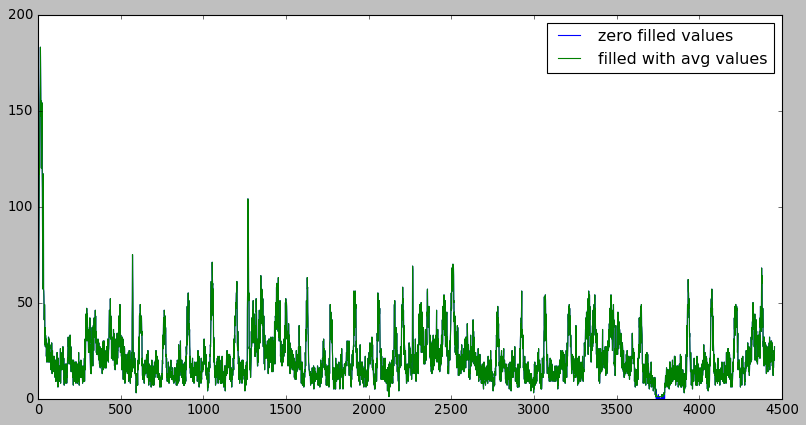

In [60]:
# Smoothing vs filling
# Sample plot that shows two variations of filling missing values
# We have taken the number of pickups for cluster region 2
plt.figure(figsize=(12, 6))
plt.plot(jan_2015_fill[4464:8920], label="zero filled values")
plt.plot(jan_2015_smooth[4464:8920], label="filled with avg values")
plt.legend()
plt.show()


We can see that we are using future values when using smoothing, which might cause data leakage.

So, we will use smoothing for jan-2015 data since it acts as our training data, and we will use simple fill_missing method for jan-2016 data.



In [61]:
# Filling missing values of jan-2016 data with 0
jan_2016_smooth = fill_missing(jan_2016_groupby['pickups_count'].values, jan_2016_unique)

# Making list of all the values of pickup data in every bin for a period of 3 months and storing them region-wise.
regions_cum = [] 


for i in range(0,40):
    regions_cum.append(jan_2016_smooth[4464*i:4464*(i+1)])

print(len(regions_cum))
print(len(regions_cum[0]))

40
4464


## Time Series and Fourier Transforms


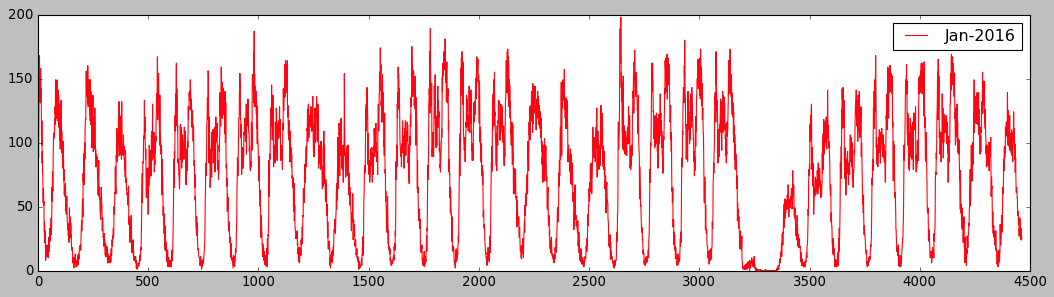

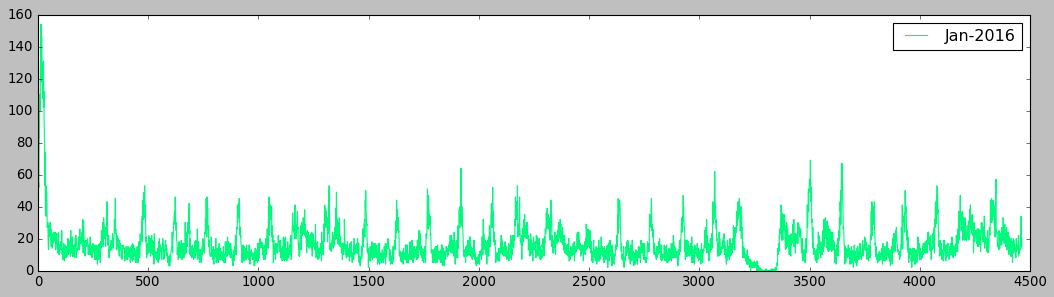

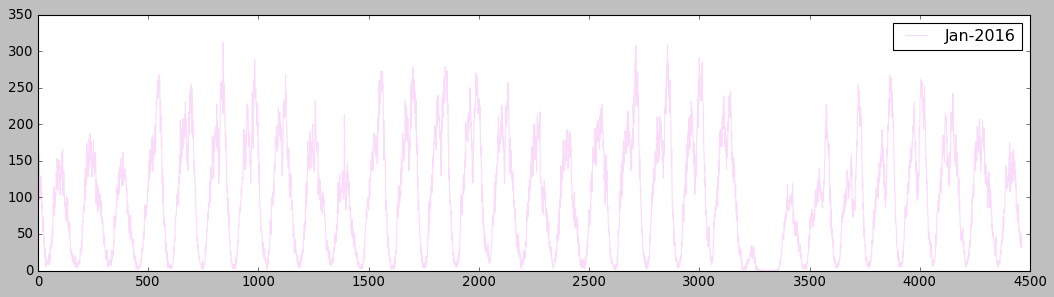

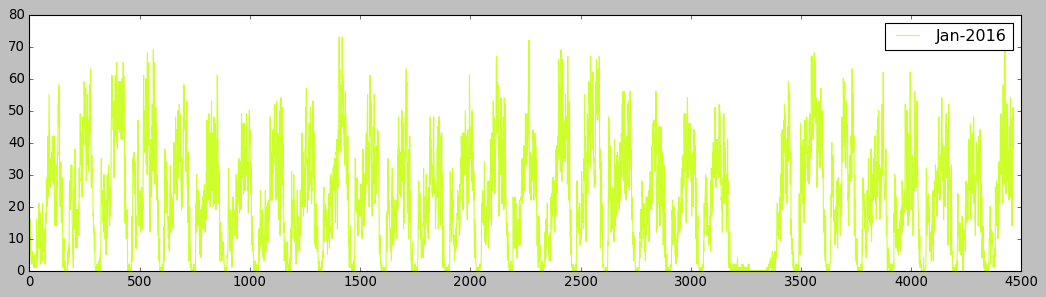

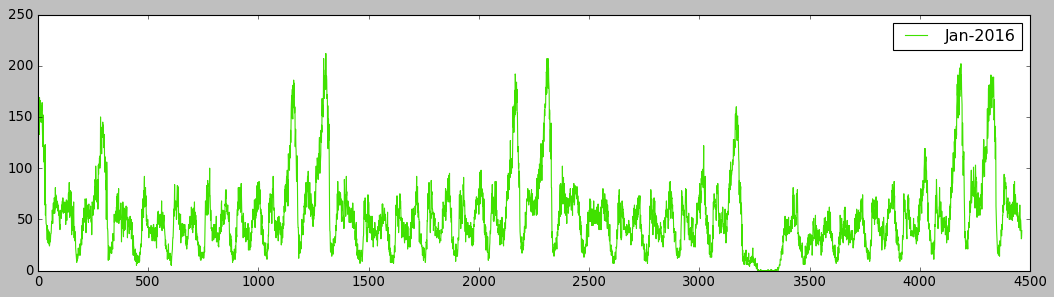

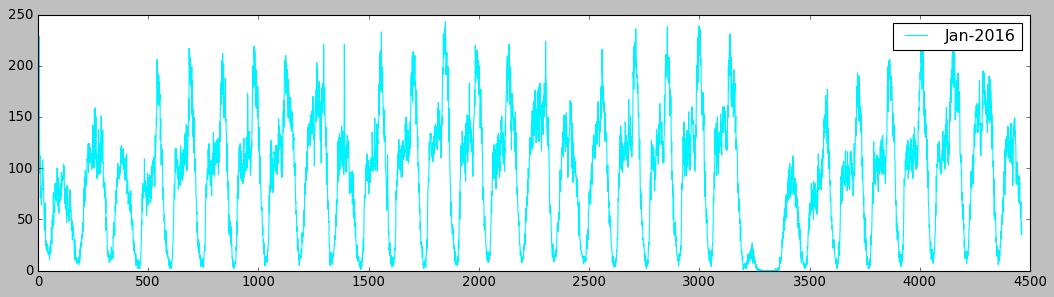

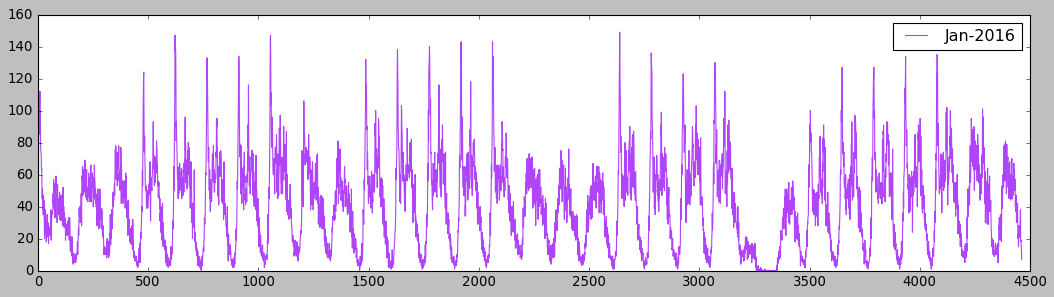

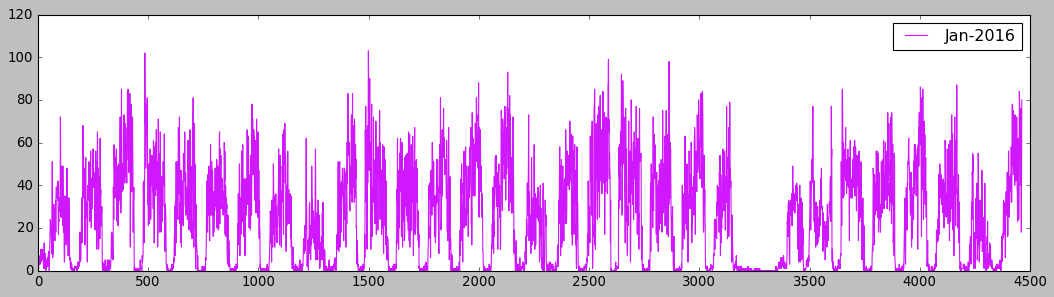

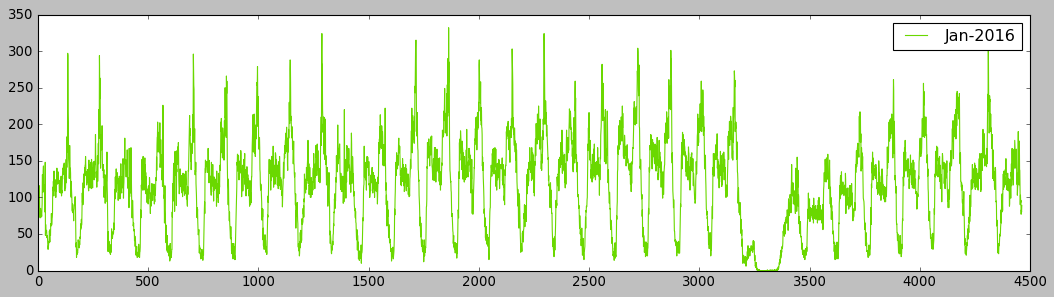

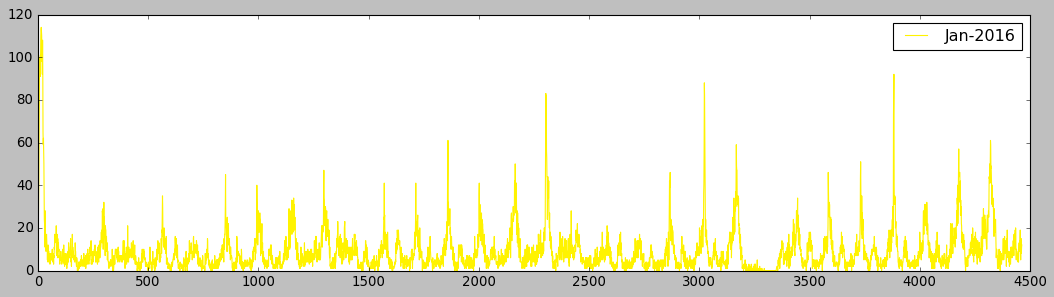

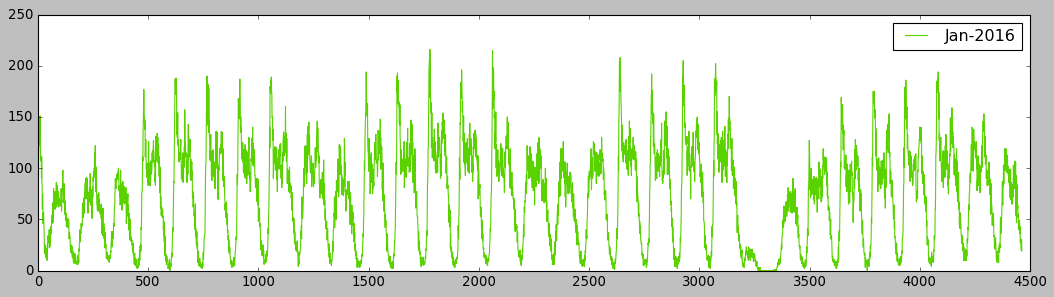

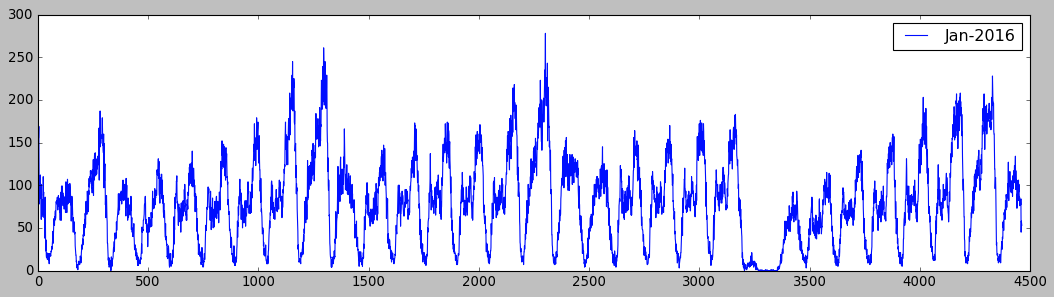

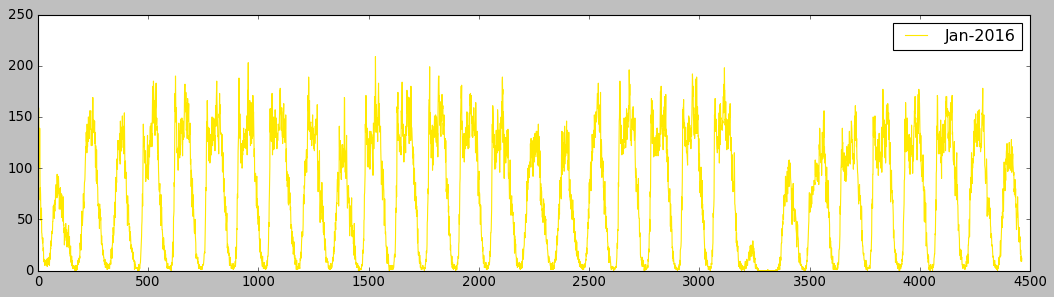

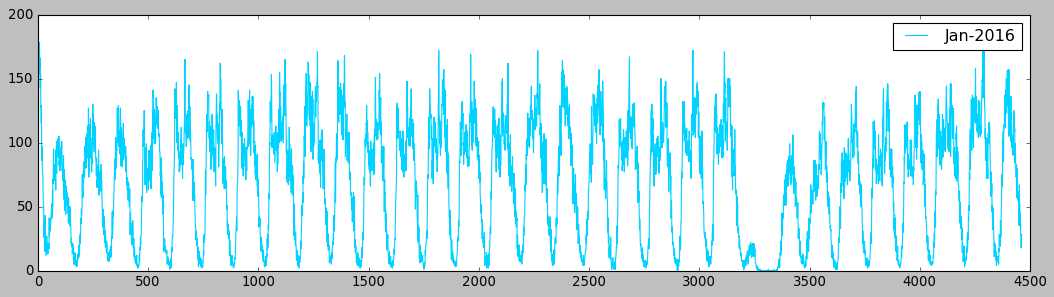

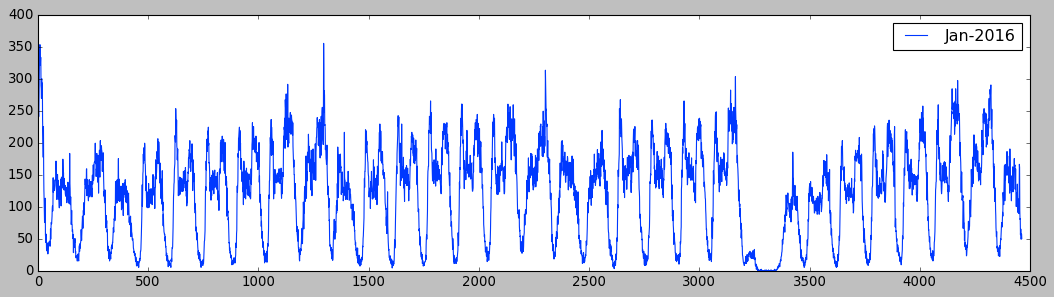

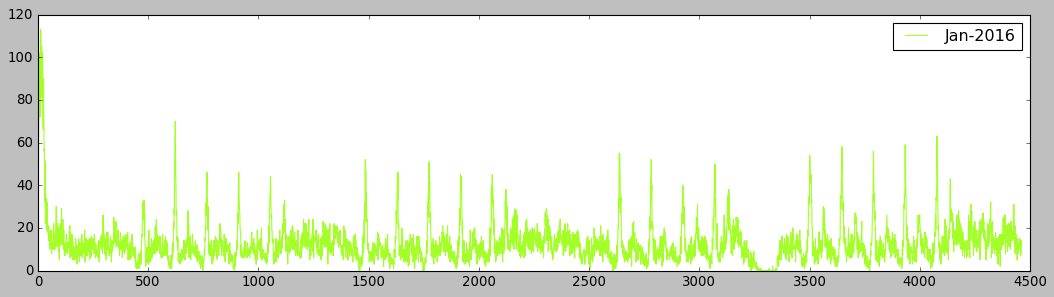

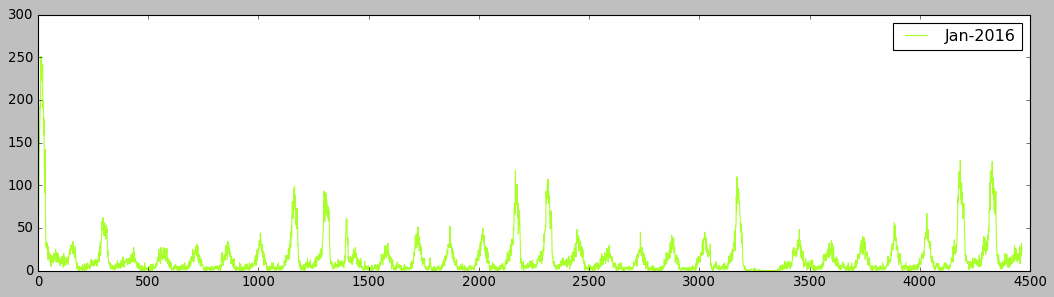

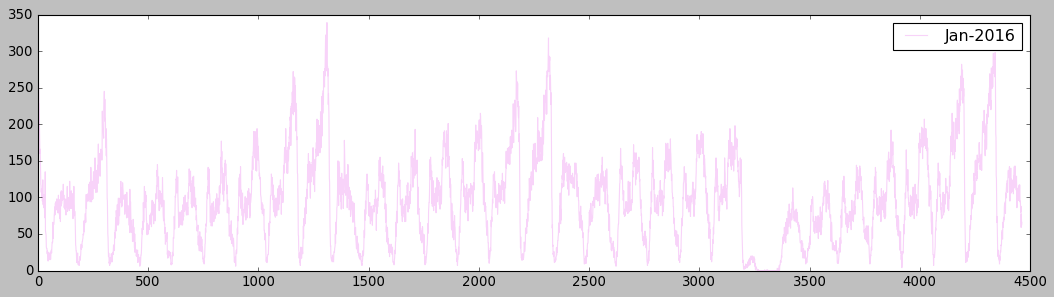

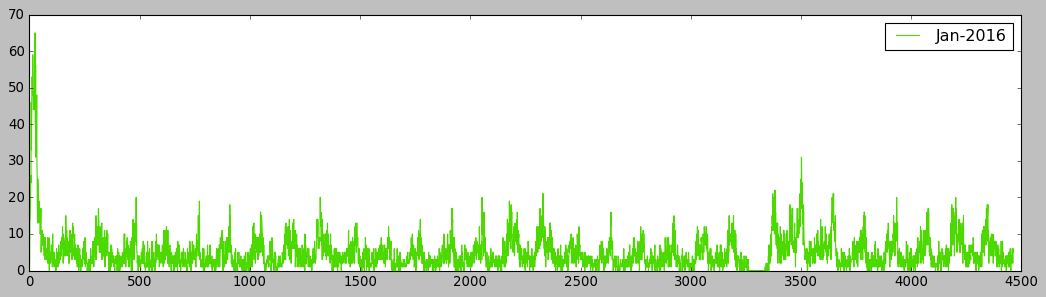

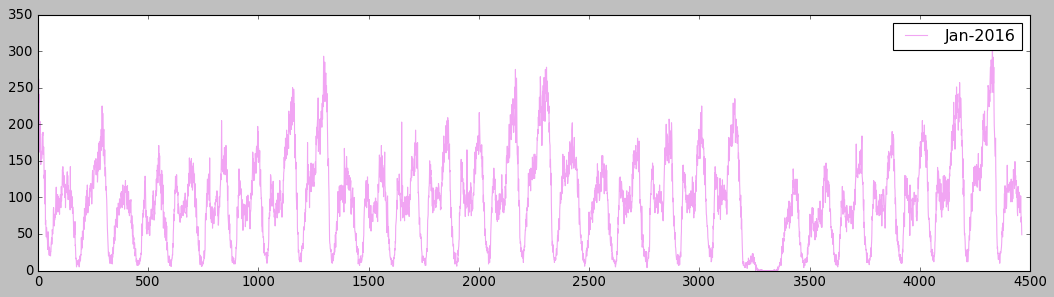

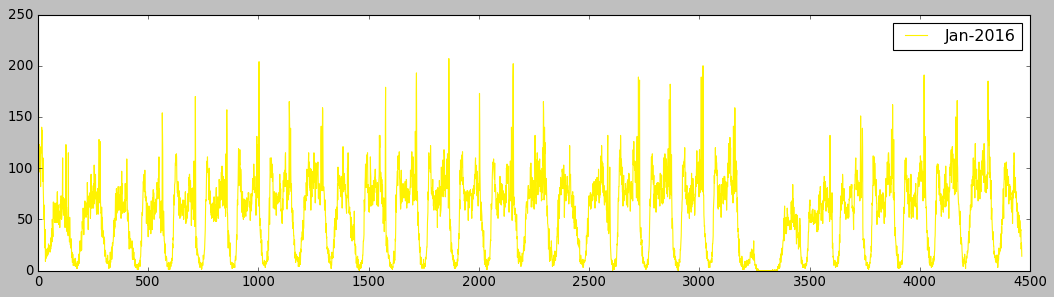

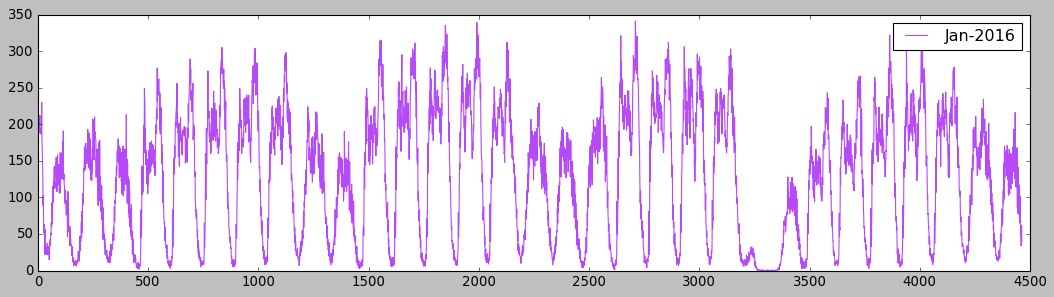

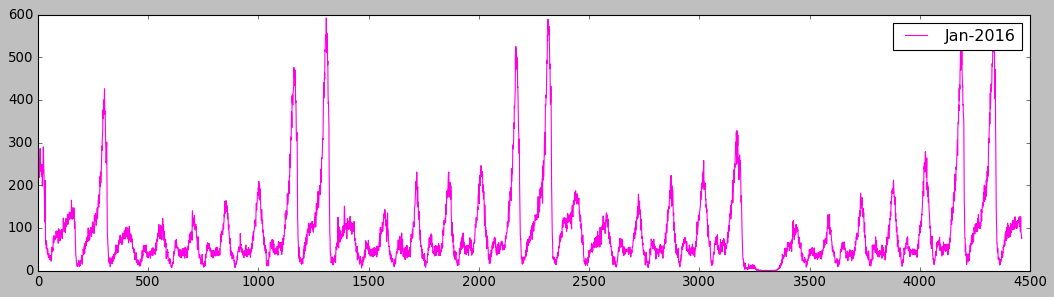

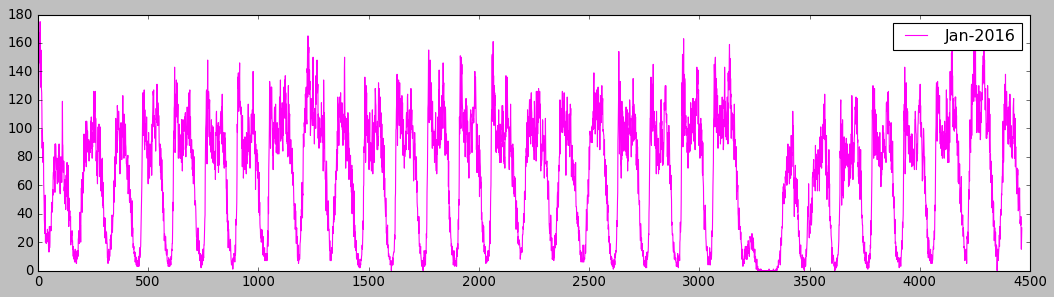

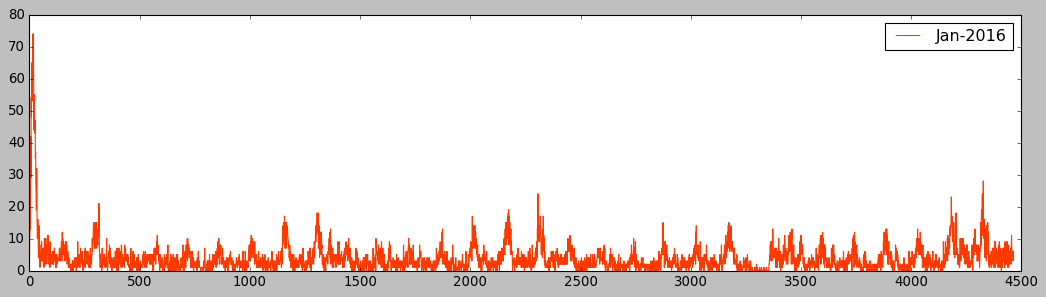

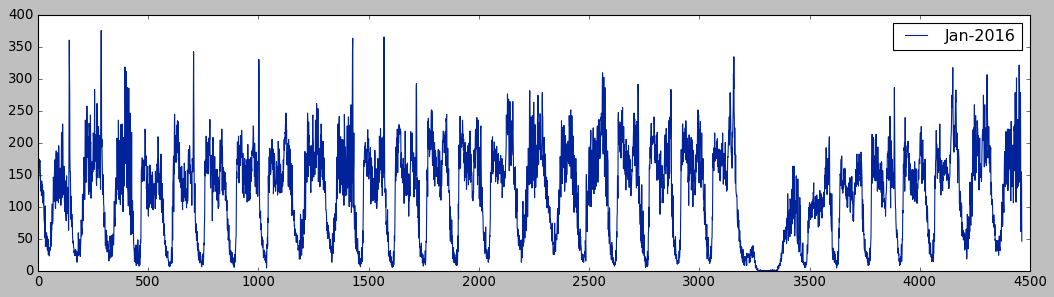

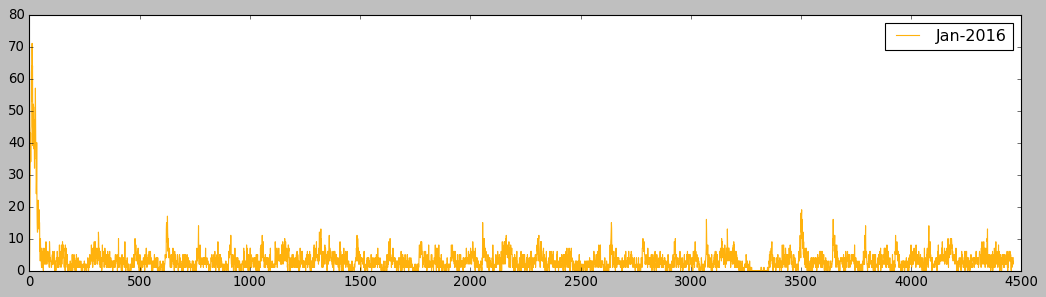

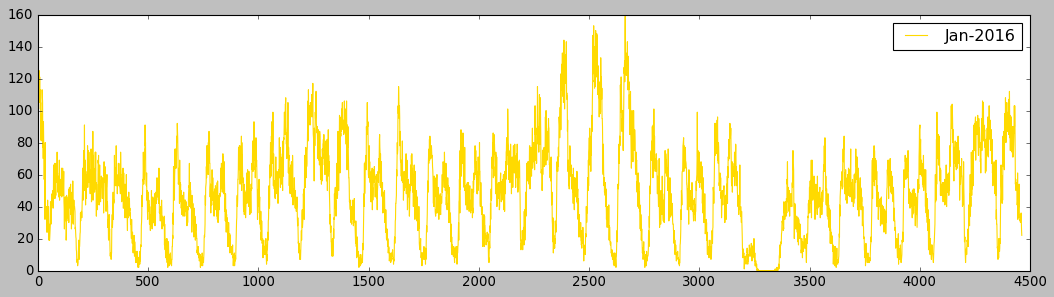

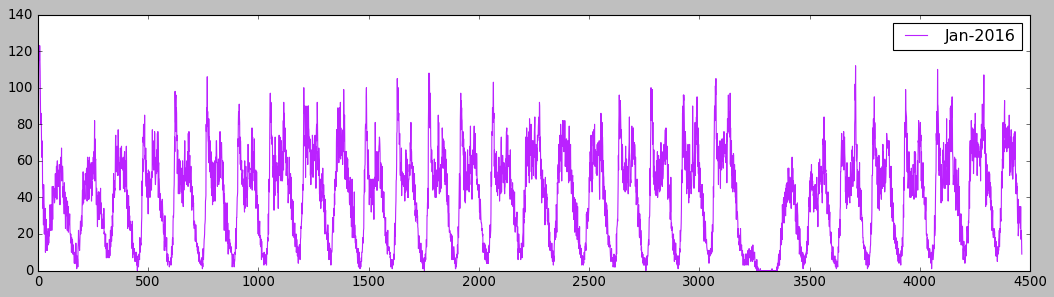

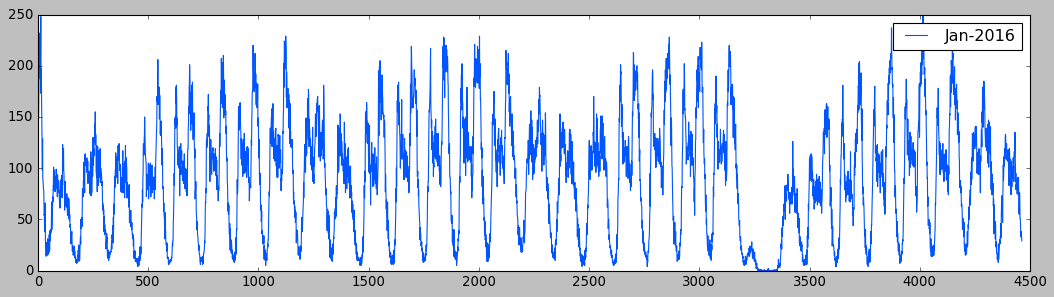

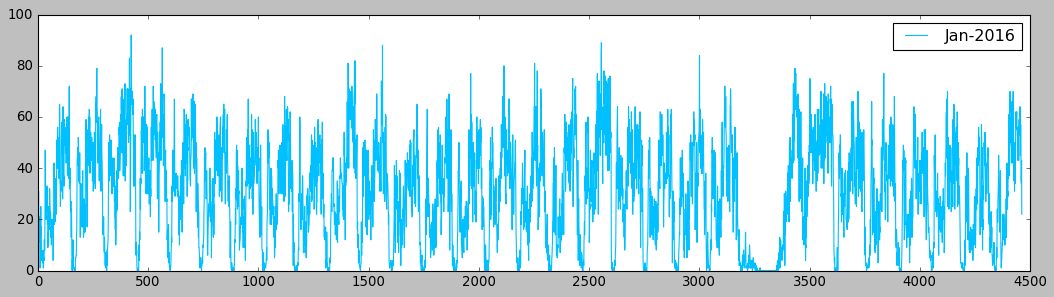

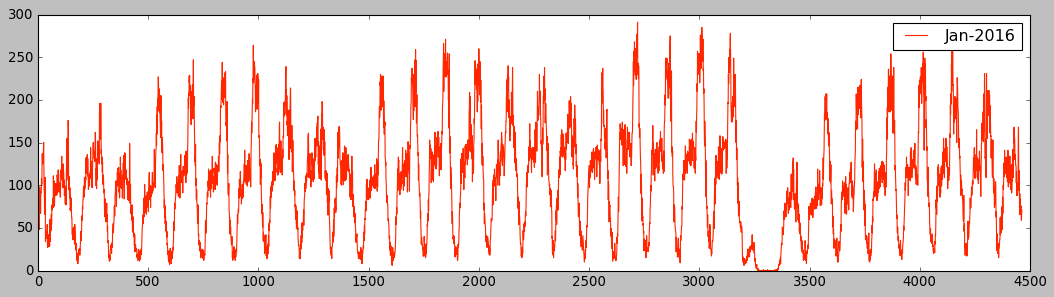

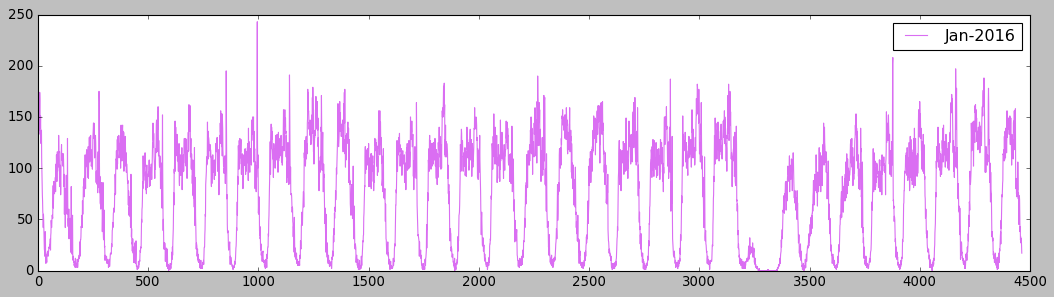

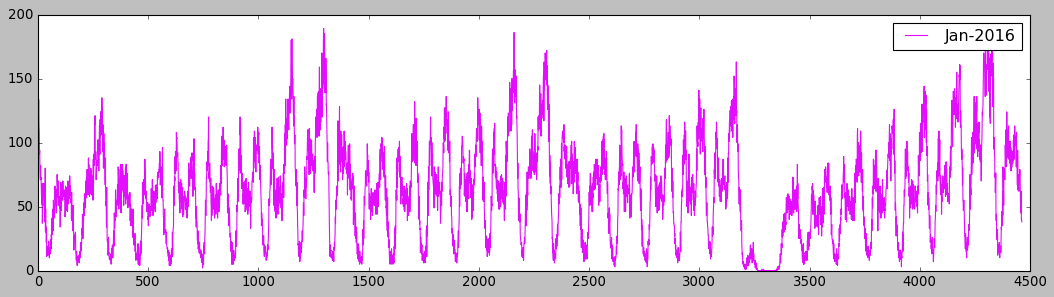

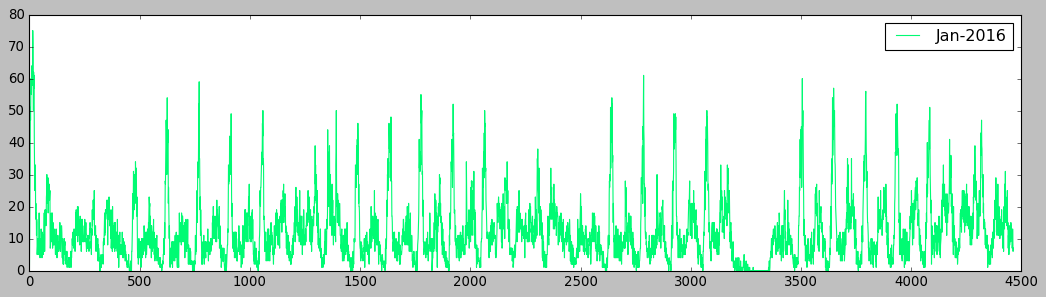

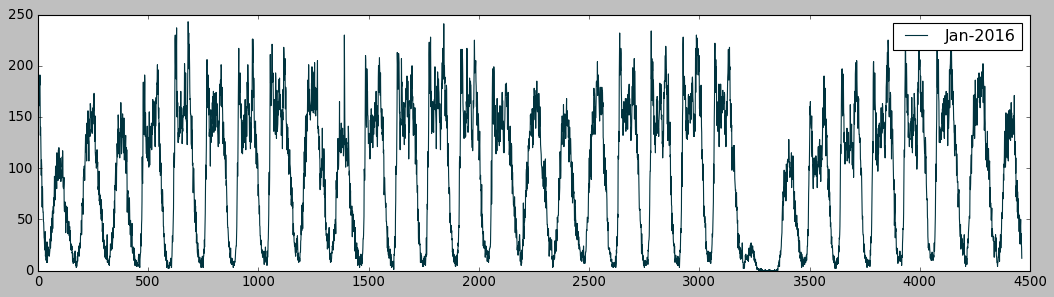

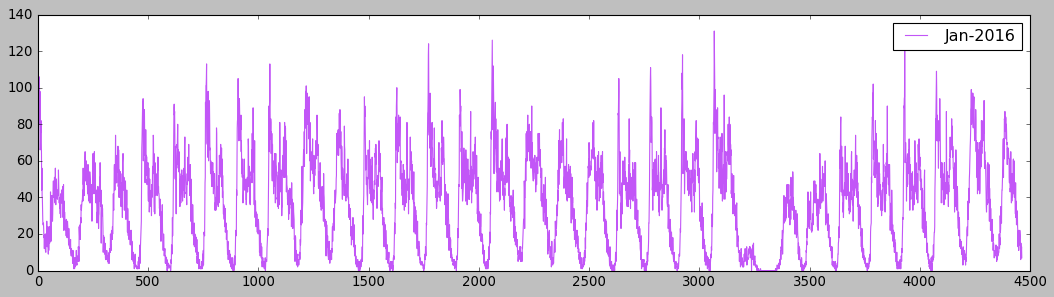

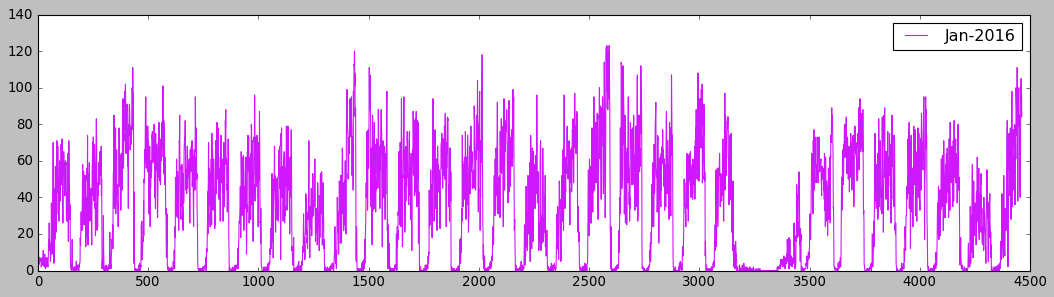

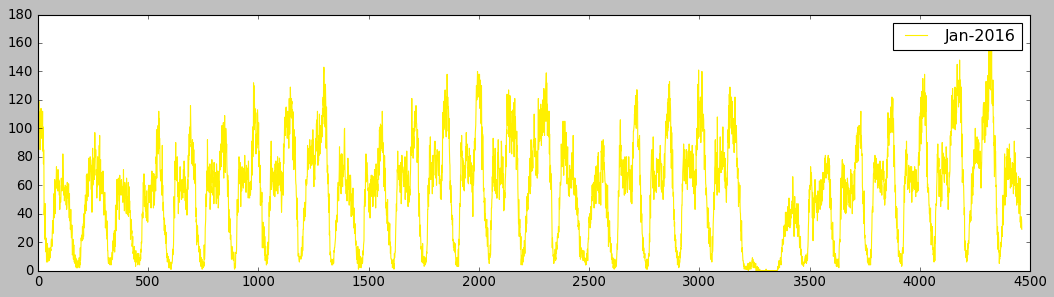

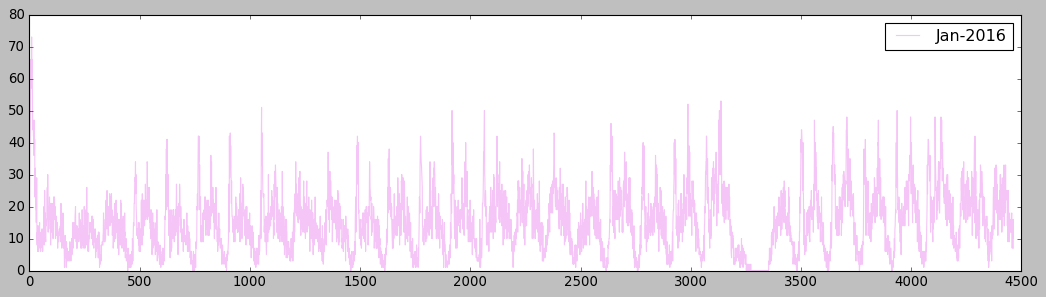

In [62]:
def unique_color():
    return plt.cm.gist_ncar(np.random.random())

first_x = list(range(4464))

# Plotting the time series for all clusters
for i in range(40):
    plt.figure(figsize=(16,4))
    plt.plot(first_x, regions_cum[i], color=unique_color(), label='Jan-2016')
    plt.legend()
    plt.show()



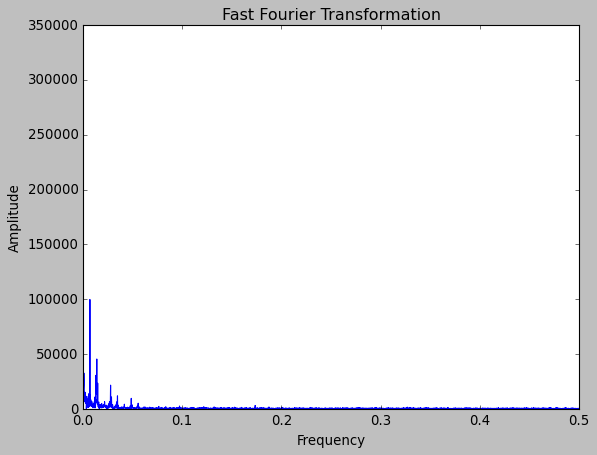

In [63]:
# Getting peaks: https://blog.ytotech.com/2015/11/01/findpeaks-in-python/
# Read more about fft function: https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fft.html
Y = np.fft.fft(np.array(jan_2016_smooth)[:4460])

# Read more about the fftfreq: https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fftfreq.html
freq = np.fft.fftfreq(4460, 1)
n = len(freq)
plt.figure()
plt.plot(freq[:int(n/2)], np.abs(Y)[:int(n/2)])
plt.title('Fast Fourier Transformation')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.show()



# Modeling: Baseline Models

Now we get into modeling in order to forecast the pickup densities for the January month of 2016 for which we are using multiple models with two variations.

1. Using ratios of the 2016 data to the 2015 data i.e. <b>R<sub>t</sub> = P<sub>t</sub><sup>2016</sup>/P<sub>t</sub><sup>2015</sup></b>
2. Using previous known values of the 2016 data to predict the future values.



In [64]:
# Preparing the dataframe only with x(i) values as jan-2015 data and y(i) values as jan-2016
ratios_jan = pd.DataFrame()
ratios_jan['Given'] = jan_2015_smooth
ratios_jan['Prediction'] = jan_2016_smooth
ratios_jan['Ratio'] = ratios_jan['Prediction']/ratios_jan['Given']


## 1. Simple Moving Average

The first model used is the simple moving averages model which uses the ratios of previous n values in order to predict the next value using

<b>R<sub>t</sub> = (R<sub>t-1</sub> + R<sub>t-2</sub> + R<sub>t-3</sub> + _ _ _ _ + R<sub>t-n</sub>) / n</b>

In [65]:
def SMA_R(ratio_df):
    predicted_ratio = (ratio_df['Ratio'].values)[0]
    error = []
    predicted_values = []
    window_size = 3
    predicted_ratio_values = []
    for i in range(4464*40):
        if i%4464 == 0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratio_df['Given'].values)[i])*predicted_ratio))
        error.append(abs(math.pow(int(((ratio_df['Given'].values)[i])*predicted_ratio) - (ratio_df['Prediction'].values)[i], 1)))
        if i+1 >= window_size:
            predicted_ratio = sum((ratio_df['Ratio'].values)[(i+1)-window_size : (i+1)])/window_size
        else:
            predicted_ratio = sum((ratio_df['Ratio'].values)[0:(i+1)])/(i+1)

    ratio_df['SMA_R_Predicted'] = predicted_values
    ratio_df['SMA_R_Error'] = error
    mape_error = (sum(error)/len(error))/(sum(ratio_df['Prediction'].values)/len(ratio_df['Prediction'].values))
    mse_error = sum([e**2 for e in error])/len(error)
    return ratio_df, mape_error, mse_error



For above, the hyperparameter is the window size (n) which is tuned manually and it is found that the window size of 3 is optimal for getting the best results using simple moving averages of previous ratio values. Therefore we get 

<b>R<sub>t</sub> = (R<sub>t-1</sub> + R<sub>t-2</sub> + R<sub>t-3</sub>) / 3</b>



Next, we use the simple moving averages of Jan 2016 values to predict future values using

<b>P<sub>t</sub> = (P<sub>t-1</sub> + P<sub>t-2</sub> + P<sub>t-3</sub> + _ _ _ _ + P<sub>t-n</sub>) / n</b>




In [66]:
def SMA_PV(ratio_df):
    predicted_value = (ratio_df['Prediction'].values)[0]
    error = []
    predicted_values = []
    window_size = 1
    for i in range(4464*40):
        predicted_values.append(predicted_value)
        error.append(abs(math.pow(predicted_value - (ratio_df['Prediction'].values)[i], 1)))
        if i+1 >= window_size:
            predicted_value = int(sum((ratio_df['Prediction'].values)[(i+1)-window_size : (i+1)])/window_size)
        else:
            predicted_value = int(sum((ratio_df['Prediction'].values)[0:(i+1)])/(i+1))

    ratio_df['SMA_PV_Predicted'] = predicted_values
    ratio_df['SMA_PV_Error'] = error
    mape_error = (sum(error)/len(error))/(sum(ratio_df['Prediction'].values)/len(ratio_df['Prediction'].values))
    mse_error = sum([e**2 for e in error])/len(error)
    return ratio_df, mape_error, mse_error



For above, the hyperparameter is the window size (n) which is tuned manually and it is found that the window size of 1 is optimal for getting the best results using simple moving averages of past values. Therefore we get 

<b>P<sub>t</sub> = P<sub>t-1</sub>


## 2. Weighted Moving Average

Unlike simple moving average where all the ratios have the same weight of 1, in weighted moving average the recent ratios have more weight than the older ratios in a gradually decreasing order.

<b>R<sub>t</sub> = (W<sub>t-1</sub>R<sub>t-1</sub> + W<sub>t-2</sub>R<sub>t-2</sub> + W<sub>t-3</sub>R<sub>t-3</sub> + _ _ _ _ + W<sub>t-n</sub>R<sub>t-n</sub>) / (W<sub>t-1</sub> + W<sub>t-2</sub> + W<sub>t-3</sub> + _ _ _ _ + W<sub>t-n</sub>)</b>

Where, 

W<sub>t-1</sub> > W<sub>t-2</sub> > W<sub>t-3</sub> > _ _ _ _ > W<sub>t-n</sub>

In [67]:
def WMA_R(ratio_df):
    predicted_ratio = (ratio_df['Ratio'].values)[0]
    error = []
    predicted_values = []
    window_size = 5
    predicted_ratio_values = []
    for i in range(4464*40):
        if i%4464 == 0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratio_df['Given'].values)[i])*predicted_ratio))
        error.append(abs(math.pow(int(((ratio_df['Given'].values)[i])*predicted_ratio) - (ratio_df['Prediction'].values)[i], 1)))
        if i+1 >= window_size:
            sum_values = 0
            sum_of_coeff = 0
            for j in range(window_size,0,-1):
                sum_values += j*(ratio_df['Ratio'].values)[i-window_size+j]
                sum_of_coeff += j
            predicted_ratio = sum_values/sum_of_coeff
        else:
            sum_values = 0
            sum_of_coeff = 0
            for j in range(i+1,0,-1):
                sum_values += j*(ratio_df['Ratio'].values)[j-1]
                sum_of_coeff += j
            predicted_ratio = sum_values/sum_of_coeff

    ratio_df['WMA_R_Predicted'] = predicted_values
    ratio_df['WMA_R_Error'] = error
    mape_error = (sum(error)/len(error))/(sum(ratio_df['Prediction'].values)/len(ratio_df['Prediction'].values))
    mse_error = sum([e**2 for e in error])/len(error)
    return ratio_df, mape_error, mse_error



For above, the hyperparameter is the window size (n) which is tuned manually and it is found that the window size of 5 is optimal for getting the best results using weighted moving averages of previous ratio values. Therefore we get 

<b>R<sub>t</sub> = (5 x R<sub>t-1</sub> + 4 x R<sub>t-2</sub> + 3 x R<sub>t-3</sub> + 2 x R<sub>t-4</sub> + 1 x R<sub>t-5</sub>) / 15</b>



In weighted moving average for past values of Jan 2016, 

<b>P<sub>t</sub> = (W<sub>t-1</sub>P<sub>t-1</sub> + W<sub>t-2</sub>P<sub>t-2</sub> + W<sub>t-3</sub>P<sub>t-3</sub> + _ _ _ _ + W<sub>t-n</sub>P<sub>t-n</sub>) / (W<sub>t-1</sub> + W<sub>t-2</sub> + W<sub>t-3</sub> + _ _ _ _ + W<sub>t-n</sub>)<b>

Where, 

W<sub>t-1</sub> > W<sub>t-2</sub> > W<sub>t-3</sub> > _ _ _ _ > W<sub>t-n</sub>

In [68]:
def WMA_PV(ratio_df):
    predicted_value = (ratio_df['Prediction'].values)[0]
    error = []
    predicted_values = []
    window_size = 2
    for i in range(4464*40):
        predicted_values.append(predicted_value)
        error.append(abs(math.pow(predicted_value - (ratio_df['Prediction'].values)[i], 1)))
        if i+1 >= window_size:
            sum_values = 0
            sum_of_coeff = 0
            for j in range(window_size,0,-1):
                sum_values += j*(ratio_df['Prediction'].values)[i-window_size+j]
                sum_of_coeff += j
            predicted_value = sum_values/sum_of_coeff
        else:
            sum_values = 0
            sum_of_coeff = 0
            for j in range(i+1,0,-1):
                sum_values += j*(ratio_df['Prediction'].values)[j-1]
                sum_of_coeff += j
            predicted_value = sum_values/sum_of_coeff

    ratio_df['WMA_PV_Predicted'] = predicted_values
    ratio_df['WMA_PV_Error'] = error
    mape_error = (sum(error)/len(error))/(sum(ratio_df['Prediction'].values)/len(ratio_df['Prediction'].values))
    mse_error = sum([e**2 for e in error])/len(error)
    return ratio_df, mape_error, mse_error



For above, the hyperparameter is the window size (n) which is tuned manually and it is found that the window size of 2 is optimal for getting the best results using weighted moving averages of previous values for Jan 2016. Therefore we get 

<b>P<sub>t</sub> = (2 x P<sub>t-1</sub> + 1 x P<sub>t-2</sub>) / 3</b>



## 3. Exponentially Weighted Moving Average

Through weighted moving average we have satisfied the analogy of giving higher weights to the latest values and decreasing weights to the subsequent older ones. But we still don't know which is the correct weighing scheme as there are infinitely many possibilities in which we can assign weights in a decreasing order and tune the hyperparameter window-size. To simplify this process, we use exponential weighted moving average, which is a more logical way towards assigning weights and at the same time also using an optimal window size.

In exponential weighted moving average we use a single hyperparameter alpha (α) which is a value between 0 and 1 and based on the value of the hyperparameter α, the weights and the window size are configured.

For example if α = 0.9 then the number of observations on which the value of the current iteration is based is ~ 1 / (1-α) = 10 i.e. we consider values till 10 observations prior to predict the value of the current iteration. Also, the weights are assigned using 2 / (N+1) = 0.18, where N = number of prior values being considered. Hence from this, it is implied that the first or the latest value is assigned a weight of 0.18 which keeps exponentially decreasing for the subsequent values.

<b>R&#770;<sub>t</sub> = αR&#770;<sub>t-1</sub> + (1 - α)R<sub>t-1</sub></b>

Here α is called the smoothing parameter and, 0 < α < 1. 

As α decreases, the recent observations become more significant than the older observations.



In [69]:
def EWMA_R(ratio_df):
    predicted_ratio = (ratio_df['Ratio'].values)[0]
    alpha = 0.6
    error = []
    predicted_values = []
    predicted_ratio_values = []
    for i in range(4464*40):
        if i%4464 == 0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratio_df['Given'].values)[i])*predicted_ratio))
        error.append(abs(math.pow(int(((ratio_df['Given'].values)[i])*predicted_ratio) - (ratio_df['Prediction'].values)[i], 1)))
        predicted_ratio = (alpha*predicted_ratio) + (1-alpha)*((ratio_df['Ratio'].values)[i])

    ratio_df['EWMA_R_Predicted'] = predicted_values
    ratio_df['EWMA_R_Error'] = error
    mape_error = (sum(error)/len(error))/(sum(ratio_df['Prediction'].values)/len(ratio_df['Prediction'].values))
    mse_error = sum([e**2 for e in error])/len(error)
    return ratio_df, mape_error, mse_error



<b>P&#770;<sub>t</sub> = αP&#770;<sub>t-1</sub> + (1 - α)P<sub>t-1</sub></b>



In [70]:
def EWMA_PV(ratio_df):
    predicted_value = (ratio_df['Prediction'].values)[0]
    alpha = 0.3
    error = []
    predicted_values = []
    for i in range(4464*40):
        if i%4464 == 0:
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_values.append(predicted_value)
        error.append(abs(math.pow(predicted_value - (ratio_df['Prediction'].values)[i], 1)))
        predicted_value = int((alpha*predicted_value) + (1-alpha)*((ratio_df['Prediction'].values)[i]))

    ratio_df['EWMA_PV_Predicted'] = predicted_values
    ratio_df['EWMA_PV_Error'] = error
    mape_error = (sum(error)/len(error))/(sum(ratio_df['Prediction'].values)/len(ratio_df['Prediction'].values))
    mse_error = sum([e**2 for e in error])/len(error)
    return ratio_df, mape_error, mse_error



In [71]:
mape_error = [0]*10
mse_error = [0]*10
ratios_jan, mape_error[0], mse_error[0] = SMA_R(ratios_jan)
ratios_jan, mape_error[1], mse_error[1] = SMA_PV(ratios_jan)
ratios_jan, mape_error[2], mse_error[2] = WMA_R(ratios_jan)
ratios_jan, mape_error[3], mse_error[3] = WMA_PV(ratios_jan)
ratios_jan, mape_error[4], mse_error[4] = EWMA_R(ratios_jan)
ratios_jan, mape_error[5], mse_error[5] = EWMA_PV(ratios_jan)



### Comparison between baseline models

We have chosen our error metric for comparison between the models as <b>MAPE (Mean Absolute Percentage Error)</b> so that we can know on an average how good our model is with predictions and <b>MSE (Mean Squared Error)</b> is also used so that we have a clearer understanding as to how well our forecasting model performs with outliers so that we make sure that there is not much of an error margin between our prediction and the actual value.



In [72]:
print("Error Metric Matrix (Forecasting Methods) - MAPE & MSE")
print("-"*150)
print("Simple Moving Average (Ratios) -                              MAPE ", mape_error[0], "          MSE:", mse_error[0])
print("Simple Moving Average (2016 Values) -                         MAPE:", mape_error[1], "          MSE:", mse_error[1])
print("-"*150)
print("Weighted Moving Average (Ratios) -                            MAPE ", mape_error[2], "           MSE:", mse_error[2])
print("Weighted Moving Average (2016 Values) -                       MAPE:", mape_error[3], "          MSE:", mse_error[3])
print("-"*150)
print("Exponential Weighted Moving Average (Ratios) -                MAPE ", mape_error[4], "          MSE:", mse_error[4])
print("Exponential Weighted Moving Average (2016 Values) -           MAPE:", mape_error[5], "          MSE:", mse_error[5])


Error Metric Matrix (Forecasting Methods) - MAPE & MSE
------------------------------------------------------------------------------------------------------------------------------------------------------
Simple Moving Average (Ratios) -                              MAPE  0.19178186522216736           MSE: 421.45580197132614
Simple Moving Average (2016 Values) -                         MAPE: 0.14675899140679008           MSE: 175.0428483422939
------------------------------------------------------------------------------------------------------------------------------------------------------
Weighted Moving Average (Ratios) -                            MAPE  0.1878899138605311            MSE: 399.566061827957
Weighted Moving Average (2016 Values) -                       MAPE: 0.13917900217618775           MSE: 161.7423467990005
------------------------------------------------------------------------------------------------------------------------------------------------------
Exponent

From the above comparison, it is inferred that the best forecasting model for our prediction is exponential weighted moving averages using 2016 values.

# Regression Models

### Creating Features

In [73]:
# Preparing to create some features

# We take the number of pickups that happened in the last 5 10-minute intervals.
number_of_intervals = 5

# Output variable - It will contain the number of pickups for each cluster
output = []

# latitudes will contain the latitude of the cluster center for every cluster
latitudes = []

# longitudes will contain the longitude of the cluster center for every cluster
longitudes = []

# weekdays will contain the day of the week that the pickup bin belongs to for each cluster
# sun=0, mon=1, tue=2, wed=3, thu=4, fri=5, sat=6
weekdays = []

# Each row in features corresponds to an entry in the data
# For the first row we will have [f0,f1,f2,f3,f4] where fi = number of pickups happened in i+1 th time interval(bin)
# The second row will have [f1,f2,f3,f4,f5]
# The third row will have [f2,f3,f4,f5,f6]
features = [0]*number_of_intervals

for i in range(40):
    latitudes.append([kmeans.cluster_centers_[i][0]]*4459)
    longitudes.append([kmeans.cluster_centers_[i][1]]*4459)
    # Jan 1st, 2016 is Thursday, so we start our day from 4
    # Our prediction starts from the 5th 10-minute interval since we need to have the number of pickups that have happened in the last five pickup bins
    weekdays.append([int(((int(k/144))%7+4)%7) for k in range(5,4464)])
    
    features = np.vstack((features, [regions_cum[i][r:r+number_of_intervals] for r in range(len(regions_cum[i])-number_of_intervals)]))
    output.append(regions_cum[i][5:])

features = features[1:]



In [74]:
len(latitudes)*len(latitudes[0]) == features.shape[0] == len(weekdays)*len(weekdays[0]) == 40*4459 == len(output)*len(output[0])

True

In [75]:
# Getting the predictions of exponential weighted moving average to be used as a feature in cumulative form
alpha = 0.3
predicted_values = []
predicted_list = []
for r in range(40):
    for i in range(4464):
        if i==0:
            predicted_value = regions_cum[r][0]
            predicted_values.append(0)
            continue
        predicted_values.append(predicted_value)
        predicted_value = int((alpha*predicted_value) + (1-alpha)*(regions_cum[r][i]))
    predicted_list.append(predicted_values[5:])
    predicted_values = []



In [76]:
# Train-test split - We don't use regular random train-test split for time-series data.
# Instead we will use time-based splitting. In time-based splitting, we generally divide the data based on a timestamp.
# Let's use 70% - 30% split
train_features = [features[i*4459:(i*4459+round(4459*0.7))] for i in range(40)]
test_features = [features[i*4459+round(4459*0.7):(i+1)*4459] for i in range(40)]


print(f"Number of data clusters: {len(train_features)}, Number of data points in train data:, {len(train_features[0])}, Each data point contains {len(train_features[0][0])} features.")
print(f"Number of data clusters: {len(test_features)}, Number of data points in train data:, {len(test_features[0])}, Each data point contains {len(test_features[0][0])} features.")



Number of data clusters: 40, Number of data points in train data:, 3121, Each data point contains 5 features.
Number of data clusters: 40, Number of data points in train data:, 1338, Each data point contains 5 features.


In [77]:
train_lat = [i[:3121] for i in latitudes]
train_long = [i[:3121] for i in longitudes]
train_weekday = [i[:3121] for i in weekdays]
train_output = [i[:3121] for i in output]
train_exp_avg = [i[:3121] for i in predicted_list]



In [78]:
test_lat = [i[3121:] for i in latitudes]
test_long = [i[3121:] for i in longitudes]
test_weekday = [i[3121:] for i in weekdays]
test_output = [i[3121:] for i in output]
test_exp_avg = [i[3121:] for i in predicted_list]



In [79]:
train_new_features = []
for i in range(40):
    train_new_features.extend(train_features[i])

test_new_features = []
for i in range(40):
    test_new_features.extend(test_features[i])



In [80]:
train_flat_lat = sum(train_lat, [])
train_flat_long = sum(train_long, [])
train_flat_weekday = sum(train_weekday, [])
train_flat_output = sum(train_output, [])
train_flat_exp_avg = sum(train_exp_avg, [])

In [81]:
test_flat_lat = sum(test_lat, [])
test_flat_long = sum(test_long, [])
test_flat_weekday = sum(test_weekday, [])
test_flat_output = sum(test_output, [])
test_flat_exp_avg = sum(test_exp_avg, [])

In [82]:
columns = ['ft_5', 'ft_4', 'ft_3', 'ft_2', 'ft_1']
df_train = pd.DataFrame(data=train_new_features, columns=columns)
df_train['latitude'] = train_flat_lat
df_train['longitude'] = train_flat_long
df_train['weekday'] = train_flat_weekday
df_train['ewm_avg'] = train_flat_exp_avg



In [83]:
df_test = pd.DataFrame(data=test_new_features, columns=columns)
df_test['latitude'] = test_flat_lat
df_test['longitude'] = test_flat_long
df_test['weekday'] = test_flat_weekday
df_test['ewm_avg'] = test_flat_exp_avg



In [84]:
df_test.head()

ft_5  ft_4  ft_3  ft_2  ft_1   latitude  longitude  weekday  ewm_avg
0   103    85    84    93    91  40.709712 -74.011243        4       90
1    85    84    93    91   116  40.709712 -74.011243        4      108
2    84    93    91   116   105  40.709712 -74.011243        4      105
3    93    91   116   105   107  40.709712 -74.011243        4      106
4    91   116   105   107   110  40.709712 -74.011243        4      108

## Linear Regression

In [85]:
lr = LinearRegression()
lr.fit(df_train, train_flat_output)

y_pred = lr.predict(df_test)
lr_test_predictions = [round(value) for value in y_pred]
y_pred = lr.predict(df_train)
lr_train_predictions = [round(value) for value in y_pred]


## RandomForest Regressor

In [86]:
rf = RandomForestRegressor(max_features='sqrt', min_samples_leaf=4, min_samples_split=3, n_jobs=-1)
rf.fit(df_train, train_flat_output)

y_pred = rf.predict(df_test)
rf_test_predictions = [round(value) for value in y_pred]
y_pred = rf.predict(df_train)
rf_train_predictions = [round(value) for value in y_pred]


In [87]:
print(df_train.columns)
print(rf.feature_importances_)

Index(['ft_5', 'ft_4', 'ft_3', 'ft_2', 'ft_1', 'latitude', 'longitude',
       'weekday', 'ewm_avg'],
      dtype='object')
[0.02803071 0.06658504 0.10464706 0.18802403 0.24741278 0.00286919
 0.00722968 0.00191266 0.35328884]


## XGBoost Regressor

In [88]:
xgbr = XGBRegressor(learning_rate=0.1, 
                    n_estimators=1000, 
                    max_depth=3, 
                    min_child_weight=3, 
                    gamma=0, 
                    subsample=0.8,
                    reg_alpha=200, reg_lambda=200,
                    colsample_bytree=0.8, 
                    nthread=8)
xgbr.fit(df_train, train_flat_output)

y_pred = xgbr.predict(df_test)
xgbr_test_predictions = [round(value) for value in y_pred]
y_pred = xgbr.predict(df_train)
xgbr_train_predictions = [round(value) for value in y_pred]


In [89]:
print(df_train.columns)
print([round(float(num),5) for num in xgbr.feature_importances_])

Index(['ft_5', 'ft_4', 'ft_3', 'ft_2', 'ft_1', 'latitude', 'longitude',
       'weekday', 'ewm_avg'],
      dtype='object')
[0.00168, 0.00095, 0.0042, 0.02279, 0.15934, 0.00199, 0.00096, 0.00075, 0.80734]


## Calculating the error for the models


In [90]:
train_mape = []
test_mape = []

train_mape.append((mean_absolute_error(train_flat_output, df_train['ft_1'].values)) / (sum(train_flat_output)/len(train_flat_output)))
train_mape.append((mean_absolute_error(train_flat_output, df_train['ewm_avg'].values)) / (sum(train_flat_output)/len(train_flat_output)))
train_mape.append((mean_absolute_error(train_flat_output, lr_train_predictions)) / (sum(train_flat_output)/len(train_flat_output)))
train_mape.append((mean_absolute_error(train_flat_output, rf_train_predictions)) / (sum(train_flat_output)/len(train_flat_output)))
train_mape.append((mean_absolute_error(train_flat_output, xgbr_train_predictions)) / (sum(train_flat_output)/len(train_flat_output)))

test_mape.append((mean_absolute_error(test_flat_output, df_test['ft_1'].values)) / (sum(test_flat_output)/len(test_flat_output)))
test_mape.append((mean_absolute_error(test_flat_output, df_test['ewm_avg'].values)) / (sum(test_flat_output)/len(test_flat_output)))
test_mape.append((mean_absolute_error(test_flat_output, lr_test_predictions)) / (sum(test_flat_output)/len(test_flat_output)))
test_mape.append((mean_absolute_error(test_flat_output, rf_test_predictions)) / (sum(test_flat_output)/len(test_flat_output)))
test_mape.append((mean_absolute_error(test_flat_output, xgbr_test_predictions)) / (sum(test_flat_output)/len(test_flat_output)))


In [91]:
print("Error Metric Matrix (Regression Methods) - MAPE")
print("-"*150)
print("Baseline Model -                                               Train ", train_mape[0], "            Test:", test_mape[0])
# print("-"*150)
print("Exponentially Weighted Moving Average Forecasting -            Train:", train_mape[1], "            Test:", test_mape[1])
# print("-"*150)
print("Linear Regression -                                            Train ", train_mape[2], "           Test:", test_mape[2])
# print("-"*150)
print("Random Forest Regressor -                                      Train ", train_mape[3], "           Test:", test_mape[3])
# print("-"*150)
print("XGBoost Regressor -                                            Train:", train_mape[4], "           Test:", test_mape[4])
print("-"*150)


Error Metric Matrix (Regression Methods) - MAPE
------------------------------------------------------------------------------------------------------------------------------------------------------
Baseline Model -                                               Train  0.1467318231011892             Test: 0.1453051823363419
Exponentially Weighted Moving Average Forecasting -            Train: 0.1388128102899903             Test: 0.13689487145977633
Linear Regression -                                            Train  0.13855727449258032            Test: 0.13784978713194085
Random Forest Regressor -                                      Train  0.09430088950608749            Test: 0.13708398763380747
XGBoost Regressor -                                            Train: 0.13422160588926912            Test: 0.13776197084637612
------------------------------------------------------------------------------------------------------------------------------------------------------
